# 数据集：abalone_benchmarks

## 导入文件包

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from diff_plt import diff_hist
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

path = "./abalone_benchmarks/abalone/benchmarks"

file_list = []

for _ in os.listdir(path):
    file_list.append(path + '/' + _)

## 数据预处理
首先对文件进行预处理，一个benchmarks文件夹里有一千多个文件，每个文件都有不同的列，因此要找出所有的文件共同的列进行处理

In [10]:
def same_columns(list1, list2):          #提取两个列表的共同元素
    set1 = set(list1)
    set2 = set(list2)
    iset = set1.intersection(set2)
    return list(iset)

list1 = pd.read_csv(file_list[0], index_col=0).columns

print("提取所有文件中的公共列：")
for file in tqdm(file_list[1:]):
    list2 = pd.read_csv(file, index_col=0).columns
    list1 = same_columns(list1, list2)

print("公共列为：", list1)

columns = list1

  0%|▏                                                                                | 5/1724 [00:00<00:36, 47.53it/s]

提取所有文件中的公共列：


100%|██████████████████████████████████████████████████████████████████████████████| 1724/1724 [00:31<00:00, 54.65it/s]

公共列为： ['origin', 'V2', 'V3', 'motherset', 'V5', 'V6', 'diff.score', 'V4', 'V7', 'V1', 'ground.truth', 'original.label']


‘origin’,‘motherset’不是数值属性 ，不对其进行考虑，并将‘ground.truth’转化为‘0,1’标签，并将数据集以7:3的比例划分为训练集和测试集，实验在训练集上对各种检测离群点的方法进行训练，再在测试集上查看各种方法的效果，并进行对比。

In [2]:
def Pre_treat(file):
      name=file[-8:-4]
      data = pd.read_csv(file, index_col=0)
      data.loc[data['ground.truth'] == 'anomaly','ground.truth'] = 1
      data.loc[data['ground.truth'] == 'nominal','ground.truth'] = 0
      columns = [ 'diff.score', 'original.label', 'V1','V2', 'V3', 'V4', 'V5', 'V6', 'V7']
      x = data[columns]
      y = data['ground.truth']
      x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)
      return x_train, x_test, y_train, y_test,name

## 模型选取
本次实验选取KNN、LOF、PCA、IForset四种模型，并求取其在每个csv文件中的roc和pen值

In [3]:
from pyod.models.knn import KNN   
from pyod.models.lof import LOF
from pyod.models.pca import PCA
from pyod.models.iforest import IForest
from pyod.utils.data import evaluate_print
from sklearn.metrics import roc_auc_score
from sklearn.utils import column_or_1d
from sklearn.utils import check_consistent_length
from pyod.utils.utility import precision_n_scores
knn_roc = []
knn_prn = []
lof_roc = []
lof_prn = []
pca_roc = []
pca_prn = []
iforest_roc = []
iforest_prn = []
clf_name_list=[]

### KNN模型：

In [4]:
def train_knn():
    try:
        print(name)
        clf_name = 'KNN'
        clf = KNN()  # 初始化检测器clf
        clf.fit(x_train)  # 使用x_train训练检测器clf
      # 返回训练数据x_train上的异常标签和异常分值
        y_train_pred = clf.labels_  # 返回训练数据上的分类标签 (0: 正常值, 1: 异常值)
        y_train_scores = clf.decision_scores_  # 返回训练数据上的异常值 (分值越大越异常)
        print("训练集:")
        evaluate_print(clf_name, y_train, y_train_scores)
      # 用训练好的clf来预测未知数据中的异常值
        y_test_pred = clf.predict(x_test)  # 返回未知数据上的分类标签 (0: 正常值, 1: 异常值)
        y_test_scores = clf.decision_function(x_test)  # 返回未知数据上的异常值 (分值越大越异常)
        print("测试集:")
        evaluate_print(clf_name, y_test, y_test_scores)
        y_true = column_or_1d(y_test)
        y_pred = column_or_1d(y_test_scores)
        check_consistent_length(y_true, y_pred)
        roc = np.round(roc_auc_score(y_true, y_pred), decimals=4)
        prn = np.round(precision_n_scores(y_true, y_pred), decimals=4)
        knn_roc.append(roc)
        knn_prn.append(prn)
        clf_name_list.append(name)
    except:
        print(name+'只有一个类，跳过')

每个csv文件对应的KNN模型ROC值和PRN值

In [5]:
for file in file_list:
    x_train, x_test, y_train,y_test,name = Pre_treat(file)
    y_test=list(y_test)
    y_train = list(y_train)
    train_knn()

0001
训练集:
KNN ROC:0.8306, precision @ rank n:0.7464
测试集:
KNN ROC:0.8265, precision @ rank n:0.7482
0002
训练集:
KNN ROC:0.8201, precision @ rank n:0.7446
测试集:
KNN ROC:0.8369, precision @ rank n:0.7811
0003
训练集:
KNN ROC:0.8079, precision @ rank n:0.7403
测试集:
KNN ROC:0.7981, precision @ rank n:0.7273
0004
训练集:
KNN ROC:0.8226, precision @ rank n:0.7257
测试集:
KNN ROC:0.8255, precision @ rank n:0.7115
0005
训练集:
KNN ROC:0.818, precision @ rank n:0.7411
测试集:
KNN ROC:0.8031, precision @ rank n:0.7269
0006
训练集:
KNN ROC:0.8125, precision @ rank n:0.7262
测试集:
KNN ROC:0.8265, precision @ rank n:0.7483
0007
训练集:
KNN ROC:0.842, precision @ rank n:0.7524
测试集:
KNN ROC:0.8454, precision @ rank n:0.7852
0008
训练集:
KNN ROC:0.8091, precision @ rank n:0.7281
测试集:
KNN ROC:0.8232, precision @ rank n:0.7535
0009
训练集:
KNN ROC:0.817, precision @ rank n:0.7545
测试集:
KNN ROC:0.8736, precision @ rank n:0.7908
0010
训练集:
KNN ROC:0.8262, precision @ rank n:0.7408
测试集:
KNN ROC:0.8382, precision @ rank n:0.769
0011
训练集:
KNN 

测试集:
KNN ROC:0.9578, precision @ rank n:0.9076
0091
训练集:
KNN ROC:0.969, precision @ rank n:0.9154
测试集:
KNN ROC:0.9785, precision @ rank n:0.9315
0092
训练集:
KNN ROC:0.9681, precision @ rank n:0.9176
测试集:
KNN ROC:0.9688, precision @ rank n:0.9058
0093
训练集:
KNN ROC:0.9642, precision @ rank n:0.9081
测试集:
KNN ROC:0.9535, precision @ rank n:0.9068
0094
训练集:
KNN ROC:0.9747, precision @ rank n:0.9232
测试集:
KNN ROC:0.9524, precision @ rank n:0.9106
0095
训练集:
KNN ROC:0.9653, precision @ rank n:0.9196
测试集:
KNN ROC:0.958, precision @ rank n:0.912
0096
训练集:
KNN ROC:0.9561, precision @ rank n:0.8946
测试集:
KNN ROC:0.972, precision @ rank n:0.9355
0097
训练集:
KNN ROC:0.9727, precision @ rank n:0.9211
测试集:
KNN ROC:0.9554, precision @ rank n:0.9177
0098
训练集:
KNN ROC:0.9659, precision @ rank n:0.9235
测试集:
KNN ROC:0.9738, precision @ rank n:0.9277
0099
训练集:
KNN ROC:0.9687, precision @ rank n:0.9196
测试集:
KNN ROC:0.9548, precision @ rank n:0.8987
0100
训练集:
KNN ROC:0.9596, precision @ rank n:0.9106
测试集:
KNN ROC:0

训练集:
KNN ROC:0.8185, precision @ rank n:0.7253
测试集:
KNN ROC:0.7897, precision @ rank n:0.7101
0175
训练集:
KNN ROC:0.827, precision @ rank n:0.7545
测试集:
KNN ROC:0.829, precision @ rank n:0.7752
0176
训练集:
KNN ROC:0.8077, precision @ rank n:0.7223
测试集:
KNN ROC:0.842, precision @ rank n:0.7621
0177
训练集:
KNN ROC:0.8086, precision @ rank n:0.7282
测试集:
KNN ROC:0.7994, precision @ rank n:0.7282
0178
训练集:
KNN ROC:0.8428, precision @ rank n:0.7735
测试集:
KNN ROC:0.8225, precision @ rank n:0.7509
0179
训练集:
KNN ROC:0.8335, precision @ rank n:0.7527
测试集:
KNN ROC:0.8382, precision @ rank n:0.7518
0180
训练集:
KNN ROC:0.8176, precision @ rank n:0.7469
测试集:
KNN ROC:0.8125, precision @ rank n:0.7622
0181
训练集:
KNN ROC:0.7978, precision @ rank n:0.724
测试集:
KNN ROC:0.7844, precision @ rank n:0.7101
0182
训练集:
KNN ROC:0.8372, precision @ rank n:0.7388
测试集:
KNN ROC:0.8106, precision @ rank n:0.7321
0183
训练集:
KNN ROC:0.793, precision @ rank n:0.7164
测试集:
KNN ROC:0.7781, precision @ rank n:0.6942
0184
训练集:
KNN ROC:0.

测试集:
KNN ROC:0.5505, precision @ rank n:0.4268
0258
训练集:
KNN ROC:0.5681, precision @ rank n:0.4457
测试集:
KNN ROC:0.5399, precision @ rank n:0.4257
0259
训练集:
KNN ROC:0.5571, precision @ rank n:0.4167
测试集:
KNN ROC:0.5863, precision @ rank n:0.4539
0260
训练集:
KNN ROC:0.5642, precision @ rank n:0.4184
测试集:
KNN ROC:0.5502, precision @ rank n:0.4371
0261
训练集:
KNN ROC:0.5465, precision @ rank n:0.3983
测试集:
KNN ROC:0.5836, precision @ rank n:0.4359
0262
训练集:
KNN ROC:0.547, precision @ rank n:0.4035
测试集:
KNN ROC:0.5168, precision @ rank n:0.3134
0263
训练集:
KNN ROC:0.5297, precision @ rank n:0.4041
测试集:
KNN ROC:0.5742, precision @ rank n:0.4043
0264
训练集:
KNN ROC:0.56, precision @ rank n:0.3958
测试集:
KNN ROC:0.5709, precision @ rank n:0.4451
0265
训练集:
KNN ROC:0.5242, precision @ rank n:0.3864
测试集:
KNN ROC:0.5173, precision @ rank n:0.3681
0266
训练集:
KNN ROC:0.5547, precision @ rank n:0.4006
测试集:
KNN ROC:0.5213, precision @ rank n:0.3333
0267
训练集:
KNN ROC:0.588, precision @ rank n:0.4187
测试集:
KNN ROC:0

0476
训练集:
0476只有一个类，跳过
0477
训练集:
0477只有一个类，跳过
0478
训练集:
0478只有一个类，跳过
0479
训练集:
0479只有一个类，跳过
0480
训练集:
0480只有一个类，跳过
0481
训练集:
0481只有一个类，跳过
0482
训练集:
0482只有一个类，跳过
0483
训练集:
0483只有一个类，跳过
0484
训练集:
0484只有一个类，跳过
0485
训练集:
0485只有一个类，跳过
0486
训练集:
0486只有一个类，跳过
0487
训练集:
0487只有一个类，跳过
0488
训练集:
0488只有一个类，跳过
0489
训练集:
0489只有一个类，跳过
0490
训练集:
0490只有一个类，跳过
0491
训练集:
0491只有一个类，跳过
0492
训练集:
0492只有一个类，跳过
0493
训练集:
0493只有一个类，跳过
0494
训练集:
0494只有一个类，跳过
0495
训练集:
0495只有一个类，跳过
0496
训练集:
0496只有一个类，跳过
0497
训练集:
0497只有一个类，跳过
0498
训练集:
0498只有一个类，跳过
0499
训练集:
0499只有一个类，跳过
0500
训练集:
0500只有一个类，跳过
0501
训练集:
0501只有一个类，跳过
0502
训练集:
KNN ROC:1.0, precision @ rank n:1.0
测试集:
KNN ROC:1.0, precision @ rank n:1.0
0503
训练集:
0503只有一个类，跳过
0504
训练集:
KNN ROC:1.0, precision @ rank n:1.0
测试集:
KNN ROC:0.9981, precision @ rank n:0.0
0505
训练集:
0505只有一个类，跳过
0506
训练集:
0506只有一个类，跳过
0507
训练集:
0507只有一个类，跳过
0508
训练集:
0508只有一个类，跳过
0509
训练集:
0509只有一个类，跳过
0510
训练集:
KNN ROC:1.0, precision @ rank n:1.0
测试集:
KNN ROC:0.994, precision @ rank n:0.

测试集:
KNN ROC:0.9965, precision @ rank n:0.5
0608
训练集:
KNN ROC:0.995, precision @ rank n:0.6667
测试集:
KNN ROC:0.9938, precision @ rank n:0.5
0609
训练集:
KNN ROC:0.9966, precision @ rank n:0.8333
测试集:
KNN ROC:0.9885, precision @ rank n:0.5
0610
训练集:
KNN ROC:0.9966, precision @ rank n:0.5
测试集:
KNN ROC:0.9902, precision @ rank n:0.3333
0611
训练集:
KNN ROC:0.9935, precision @ rank n:0.3333
测试集:
KNN ROC:0.9967, precision @ rank n:0.5714
0612
训练集:
KNN ROC:0.9906, precision @ rank n:0.6
测试集:
KNN ROC:0.9887, precision @ rank n:0.4
0613
训练集:
KNN ROC:0.9949, precision @ rank n:0.8
测试集:
KNN ROC:0.9972, precision @ rank n:0.6
0614
训练集:
KNN ROC:0.9937, precision @ rank n:0.5714
测试集:
KNN ROC:0.9835, precision @ rank n:0.0
0615
训练集:
KNN ROC:0.9874, precision @ rank n:0.4286
测试集:
KNN ROC:0.9953, precision @ rank n:0.6667
0616
训练集:
KNN ROC:0.995, precision @ rank n:0.5
测试集:
KNN ROC:0.9973, precision @ rank n:0.75
0617
训练集:
KNN ROC:0.9915, precision @ rank n:0.25
测试集:
KNN ROC:0.9947, precision @ rank n:0.6667

测试集:
KNN ROC:1.0, precision @ rank n:1.0
0699
训练集:
KNN ROC:0.9996, precision @ rank n:0.75
测试集:
KNN ROC:1.0, precision @ rank n:1.0
0700
训练集:
KNN ROC:0.9989, precision @ rank n:0.6667
测试集:
KNN ROC:1.0, precision @ rank n:1.0
0701
训练集:
KNN ROC:1.0, precision @ rank n:1.0
测试集:
KNN ROC:1.0, precision @ rank n:1.0
0702
训练集:
KNN ROC:1.0, precision @ rank n:1.0
测试集:
KNN ROC:1.0, precision @ rank n:1.0
0703
训练集:
KNN ROC:1.0, precision @ rank n:1.0
测试集:
0703只有一个类，跳过
0704
训练集:
KNN ROC:1.0, precision @ rank n:1.0
测试集:
KNN ROC:1.0, precision @ rank n:1.0
0705
训练集:
KNN ROC:1.0, precision @ rank n:1.0
测试集:
0705只有一个类，跳过
0706
训练集:
KNN ROC:1.0, precision @ rank n:1.0
测试集:
0706只有一个类，跳过
0707
训练集:
KNN ROC:1.0, precision @ rank n:1.0
测试集:
KNN ROC:1.0, precision @ rank n:1.0
0708
训练集:
KNN ROC:1.0, precision @ rank n:1.0
测试集:
KNN ROC:1.0, precision @ rank n:1.0
0709
训练集:
KNN ROC:1.0, precision @ rank n:1.0
测试集:
KNN ROC:1.0, precision @ rank n:1.0
0710
训练集:
KNN ROC:1.0, precision @ rank n:1.0
测试集:
KNN ROC:1.

测试集:
KNN ROC:0.9962, precision @ rank n:0.8333
0793
训练集:
KNN ROC:0.9994, precision @ rank n:0.75
测试集:
KNN ROC:0.9974, precision @ rank n:0.5
0794
训练集:
KNN ROC:0.9968, precision @ rank n:0.6667
测试集:
KNN ROC:0.9858, precision @ rank n:0.25
0795
训练集:
KNN ROC:0.9949, precision @ rank n:0.6
测试集:
KNN ROC:0.995, precision @ rank n:0.6
0796
训练集:
KNN ROC:0.9985, precision @ rank n:0.75
测试集:
KNN ROC:0.9944, precision @ rank n:0.6667
0797
训练集:
KNN ROC:0.9909, precision @ rank n:0.25
测试集:
KNN ROC:0.9888, precision @ rank n:0.5
0798
训练集:
KNN ROC:0.9918, precision @ rank n:0.5
测试集:
KNN ROC:0.9885, precision @ rank n:0.25
0799
训练集:
KNN ROC:0.9905, precision @ rank n:0.6
测试集:
KNN ROC:0.9996, precision @ rank n:0.8
0800
训练集:
KNN ROC:0.9961, precision @ rank n:0.5
测试集:
KNN ROC:0.9942, precision @ rank n:0.5
0801
训练集:
KNN ROC:0.9909, precision @ rank n:0.4
测试集:
KNN ROC:0.9947, precision @ rank n:0.6
0802
训练集:
KNN ROC:0.997, precision @ rank n:0.5714
测试集:
KNN ROC:0.9865, precision @ rank n:0.3333
0803
训练集

测试集:
KNN ROC:0.9971, precision @ rank n:0.0
0881
训练集:
KNN ROC:0.9545, precision @ rank n:0.0
测试集:
KNN ROC:0.9765, precision @ rank n:0.0
0882
训练集:
KNN ROC:0.9592, precision @ rank n:0.2
测试集:
KNN ROC:1.0, precision @ rank n:1.0
0883
训练集:
KNN ROC:0.9774, precision @ rank n:0.0
测试集:
KNN ROC:0.9956, precision @ rank n:0.5
0884
训练集:
KNN ROC:0.9874, precision @ rank n:0.6
测试集:
KNN ROC:0.9853, precision @ rank n:0.0
0885
训练集:
KNN ROC:0.9584, precision @ rank n:0.2
测试集:
KNN ROC:0.9357, precision @ rank n:0.0
0886
训练集:
KNN ROC:0.9815, precision @ rank n:0.0
测试集:
KNN ROC:0.9854, precision @ rank n:0.0
0887
训练集:
KNN ROC:0.9665, precision @ rank n:0.4
测试集:
KNN ROC:0.9853, precision @ rank n:0.0
0888
训练集:
KNN ROC:0.9707, precision @ rank n:0.4
测试集:
KNN ROC:0.9472, precision @ rank n:0.0
0889
训练集:
KNN ROC:0.9683, precision @ rank n:0.0
测试集:
KNN ROC:0.9707, precision @ rank n:0.5
0890
训练集:
KNN ROC:0.982, precision @ rank n:0.3333
测试集:
KNN ROC:0.9833, precision @ rank n:0.3333
0891
训练集:
KNN ROC:0.9766

测试集:
KNN ROC:1.0, precision @ rank n:1.0
0967
训练集:
KNN ROC:1.0, precision @ rank n:1.0
测试集:
KNN ROC:1.0, precision @ rank n:1.0
0968
训练集:
KNN ROC:1.0, precision @ rank n:1.0
测试集:
KNN ROC:1.0, precision @ rank n:1.0
0969
训练集:
KNN ROC:1.0, precision @ rank n:1.0
测试集:
KNN ROC:1.0, precision @ rank n:1.0
0970
训练集:
KNN ROC:1.0, precision @ rank n:1.0
测试集:
KNN ROC:1.0, precision @ rank n:1.0
0971
训练集:
KNN ROC:0.9998, precision @ rank n:0.875
测试集:
KNN ROC:1.0, precision @ rank n:1.0
0972
训练集:
KNN ROC:1.0, precision @ rank n:1.0
测试集:
KNN ROC:1.0, precision @ rank n:1.0
0973
训练集:
KNN ROC:1.0, precision @ rank n:1.0
测试集:
KNN ROC:1.0, precision @ rank n:1.0
0974
训练集:
KNN ROC:1.0, precision @ rank n:1.0
测试集:
KNN ROC:1.0, precision @ rank n:1.0
0975
训练集:
KNN ROC:1.0, precision @ rank n:1.0
测试集:
KNN ROC:1.0, precision @ rank n:1.0
0976
训练集:
KNN ROC:0.9997, precision @ rank n:0.8
测试集:
KNN ROC:1.0, precision @ rank n:1.0
0977
训练集:
KNN ROC:1.0, precision @ rank n:1.0
测试集:
KNN ROC:1.0, precision @ rank 

测试集:
KNN ROC:0.9939, precision @ rank n:0.7143
1058
训练集:
KNN ROC:0.9954, precision @ rank n:0.7143
测试集:
KNN ROC:0.995, precision @ rank n:0.8333
1059
训练集:
KNN ROC:0.9977, precision @ rank n:0.7143
测试集:
KNN ROC:0.9947, precision @ rank n:0.6667
1060
训练集:
KNN ROC:0.9979, precision @ rank n:0.8333
测试集:
KNN ROC:0.9991, precision @ rank n:0.875
1061
训练集:
KNN ROC:0.995, precision @ rank n:0.625
测试集:
KNN ROC:0.9886, precision @ rank n:0.25
1062
训练集:
KNN ROC:0.9904, precision @ rank n:0.4375
测试集:
KNN ROC:0.9938, precision @ rank n:0.5
1063
训练集:
KNN ROC:0.9984, precision @ rank n:0.7273
测试集:
KNN ROC:0.9968, precision @ rank n:0.7778
1064
训练集:
KNN ROC:0.9893, precision @ rank n:0.4286
测试集:
KNN ROC:0.9944, precision @ rank n:0.5
1065
训练集:
KNN ROC:0.9957, precision @ rank n:0.6
测试集:
KNN ROC:0.9965, precision @ rank n:0.6
1066
训练集:
KNN ROC:0.9948, precision @ rank n:0.6364
测试集:
KNN ROC:0.9992, precision @ rank n:0.8889
1067
训练集:
KNN ROC:0.9959, precision @ rank n:0.5
测试集:
KNN ROC:0.9854, precision 

测试集:
KNN ROC:0.9584, precision @ rank n:0.2
1148
训练集:
KNN ROC:0.9759, precision @ rank n:0.375
测试集:
KNN ROC:0.9662, precision @ rank n:0.0
1149
训练集:
KNN ROC:0.964, precision @ rank n:0.1429
测试集:
KNN ROC:0.9706, precision @ rank n:0.4
1150
训练集:
KNN ROC:0.9595, precision @ rank n:0.3
测试集:
KNN ROC:0.9782, precision @ rank n:0.5
1151
训练集:
KNN ROC:0.9641, precision @ rank n:0.1429
测试集:
KNN ROC:0.974, precision @ rank n:0.4
1152
训练集:
KNN ROC:0.9704, precision @ rank n:0.4444
测试集:
KNN ROC:0.9774, precision @ rank n:0.3333
1153
训练集:
KNN ROC:0.9738, precision @ rank n:0.4286
测试集:
KNN ROC:0.9839, precision @ rank n:0.6
1154
训练集:
KNN ROC:0.9819, precision @ rank n:0.2857
测试集:
KNN ROC:0.98, precision @ rank n:0.4
1155
训练集:
KNN ROC:0.9699, precision @ rank n:0.25
测试集:
KNN ROC:0.9678, precision @ rank n:0.0
1156
训练集:
KNN ROC:0.9694, precision @ rank n:0.4
测试集:
KNN ROC:0.9519, precision @ rank n:0.0
1157
训练集:
KNN ROC:0.9782, precision @ rank n:0.375
测试集:
KNN ROC:0.9853, precision @ rank n:0.25
1158
训

测试集:
KNN ROC:0.9869, precision @ rank n:0.7941
1233
训练集:
KNN ROC:0.9867, precision @ rank n:0.6567
测试集:
KNN ROC:0.9846, precision @ rank n:0.6667
1234
训练集:
KNN ROC:0.9837, precision @ rank n:0.6528
测试集:
KNN ROC:0.986, precision @ rank n:0.6786
1235
训练集:
KNN ROC:0.9821, precision @ rank n:0.6806
测试集:
KNN ROC:0.9892, precision @ rank n:0.7857
1236
训练集:
KNN ROC:0.9838, precision @ rank n:0.6522
测试集:
KNN ROC:0.9926, precision @ rank n:0.7419
1237
训练集:
KNN ROC:0.9906, precision @ rank n:0.7246
测试集:
KNN ROC:0.9854, precision @ rank n:0.6774
1238
训练集:
KNN ROC:0.9783, precision @ rank n:0.6582
测试集:
KNN ROC:0.9867, precision @ rank n:0.6667
1239
训练集:
KNN ROC:0.9913, precision @ rank n:0.7273
测试集:
KNN ROC:0.9827, precision @ rank n:0.6765
1240
训练集:
KNN ROC:0.985, precision @ rank n:0.6622
测试集:
KNN ROC:0.9924, precision @ rank n:0.7692
1241
训练集:
KNN ROC:0.9894, precision @ rank n:0.7467
测试集:
KNN ROC:0.9886, precision @ rank n:0.68
1242
训练集:
KNN ROC:0.9868, precision @ rank n:0.6721
测试集:
KNN ROC:0

测试集:
KNN ROC:0.9988, precision @ rank n:0.9167
1320
训练集:
KNN ROC:1.0, precision @ rank n:1.0
测试集:
KNN ROC:0.9992, precision @ rank n:0.9444
1321
训练集:
KNN ROC:0.988, precision @ rank n:0.6944
测试集:
KNN ROC:0.9858, precision @ rank n:0.6786
1322
训练集:
KNN ROC:0.9915, precision @ rank n:0.7286
测试集:
KNN ROC:0.9797, precision @ rank n:0.6
1323
训练集:
KNN ROC:0.9821, precision @ rank n:0.6849
测试集:
KNN ROC:0.9829, precision @ rank n:0.5926
1324
训练集:
KNN ROC:0.9769, precision @ rank n:0.6795
测试集:
KNN ROC:0.9789, precision @ rank n:0.5909
1325
训练集:
KNN ROC:0.9917, precision @ rank n:0.7612
测试集:
KNN ROC:0.9721, precision @ rank n:0.5758
1326
训练集:
KNN ROC:0.9793, precision @ rank n:0.6471
测试集:
KNN ROC:0.9797, precision @ rank n:0.625
1327
训练集:
KNN ROC:0.9867, precision @ rank n:0.7403
测试集:
KNN ROC:0.9727, precision @ rank n:0.4783
1328
训练集:
KNN ROC:0.99, precision @ rank n:0.6912
测试集:
KNN ROC:0.9823, precision @ rank n:0.6562
1329
训练集:
KNN ROC:0.9829, precision @ rank n:0.68
测试集:
KNN ROC:0.988, preci

测试集:
KNN ROC:0.9841, precision @ rank n:0.75
1404
训练集:
KNN ROC:0.9824, precision @ rank n:0.6494
测试集:
KNN ROC:0.991, precision @ rank n:0.6957
1405
训练集:
KNN ROC:0.9861, precision @ rank n:0.6986
测试集:
KNN ROC:0.9859, precision @ rank n:0.7407
1406
训练集:
KNN ROC:0.989, precision @ rank n:0.7077
测试集:
KNN ROC:0.9862, precision @ rank n:0.6857
1407
训练集:
KNN ROC:0.9829, precision @ rank n:0.6923
测试集:
KNN ROC:0.9834, precision @ rank n:0.5909
1408
训练集:
KNN ROC:0.9892, precision @ rank n:0.7183
测试集:
KNN ROC:0.9812, precision @ rank n:0.7241
1409
训练集:
KNN ROC:0.9897, precision @ rank n:0.7361
测试集:
KNN ROC:0.9921, precision @ rank n:0.7857
1410
训练集:
KNN ROC:0.985, precision @ rank n:0.6765
测试集:
KNN ROC:0.9865, precision @ rank n:0.6875
1411
训练集:
KNN ROC:0.9814, precision @ rank n:0.5873
测试集:
KNN ROC:0.9822, precision @ rank n:0.7027
1412
训练集:
KNN ROC:0.9909, precision @ rank n:0.7344
测试集:
KNN ROC:0.9908, precision @ rank n:0.8056
1413
训练集:
KNN ROC:0.9866, precision @ rank n:0.6765
测试集:
KNN ROC:0.

测试集:
KNN ROC:0.9427, precision @ rank n:0.5
1488
训练集:
KNN ROC:0.7259, precision @ rank n:0.1591
测试集:
KNN ROC:0.8698, precision @ rank n:0.2353
1489
训练集:
KNN ROC:0.9546, precision @ rank n:0.3514
测试集:
KNN ROC:0.9212, precision @ rank n:0.3333
1490
训练集:
KNN ROC:0.8888, precision @ rank n:0.3864
测试集:
KNN ROC:0.8636, precision @ rank n:0.4118
1491
训练集:
KNN ROC:0.9123, precision @ rank n:0.22
测试集:
KNN ROC:0.8617, precision @ rank n:0.0909
1492
训练集:
KNN ROC:0.9456, precision @ rank n:0.3182
测试集:
KNN ROC:0.9044, precision @ rank n:0.2353
1493
训练集:
KNN ROC:0.8647, precision @ rank n:0.22
测试集:
KNN ROC:0.9006, precision @ rank n:0.3636
1494
训练集:
KNN ROC:0.8864, precision @ rank n:0.3404
测试集:
KNN ROC:0.798, precision @ rank n:0.0714
1495
训练集:
KNN ROC:0.9041, precision @ rank n:0.3265
测试集:
KNN ROC:0.89, precision @ rank n:0.1538
1496
训练集:
KNN ROC:0.9379, precision @ rank n:0.4043
测试集:
KNN ROC:0.8834, precision @ rank n:0.2857
1497
训练集:
KNN ROC:0.8797, precision @ rank n:0.4043
测试集:
KNN ROC:0.8614,

1571
训练集:
KNN ROC:0.9965, precision @ rank n:0.8929
测试集:
KNN ROC:0.999, precision @ rank n:0.9512
1572
训练集:
KNN ROC:0.9953, precision @ rank n:0.8788
测试集:
KNN ROC:0.9993, precision @ rank n:0.9394
1573
训练集:
KNN ROC:0.9973, precision @ rank n:0.9429
测试集:
KNN ROC:0.9974, precision @ rank n:0.8571
1574
训练集:
KNN ROC:0.9947, precision @ rank n:0.8507
测试集:
KNN ROC:0.9943, precision @ rank n:0.871
1575
训练集:
KNN ROC:0.9931, precision @ rank n:0.8714
测试集:
KNN ROC:0.999, precision @ rank n:0.931
1576
训练集:
KNN ROC:0.9993, precision @ rank n:0.9492
测试集:
KNN ROC:0.9978, precision @ rank n:0.9231
1577
训练集:
KNN ROC:0.9993, precision @ rank n:0.95
测试集:
KNN ROC:0.996, precision @ rank n:0.9231
1578
训练集:
KNN ROC:0.9998, precision @ rank n:0.9857
测试集:
KNN ROC:0.9999, precision @ rank n:0.9655
1579
训练集:
KNN ROC:0.9961, precision @ rank n:0.8841
测试集:
KNN ROC:0.9936, precision @ rank n:0.8667
1580
训练集:
KNN ROC:0.9963, precision @ rank n:0.8784
测试集:
KNN ROC:0.9975, precision @ rank n:0.9231
1581
训练集:
KNN ROC

测试集:
KNN ROC:0.9658, precision @ rank n:0.6667
1655
训练集:
KNN ROC:0.9755, precision @ rank n:0.7211
测试集:
KNN ROC:0.9782, precision @ rank n:0.7619
1656
训练集:
KNN ROC:0.9797, precision @ rank n:0.7532
测试集:
KNN ROC:0.97, precision @ rank n:0.6964
1657
训练集:
KNN ROC:0.9625, precision @ rank n:0.6645
测试集:
KNN ROC:0.9788, precision @ rank n:0.7818
1658
训练集:
KNN ROC:0.9807, precision @ rank n:0.7415
测试集:
KNN ROC:0.9794, precision @ rank n:0.746
1659
训练集:
KNN ROC:0.9761, precision @ rank n:0.731
测试集:
KNN ROC:0.9767, precision @ rank n:0.7538
1660
训练集:
KNN ROC:0.9676, precision @ rank n:0.6853
测试集:
KNN ROC:0.9772, precision @ rank n:0.7612
1661
训练集:
KNN ROC:0.9646, precision @ rank n:0.6839
测试集:
KNN ROC:0.9624, precision @ rank n:0.7273
1662
训练集:
KNN ROC:0.9781, precision @ rank n:0.7534
测试集:
KNN ROC:0.9698, precision @ rank n:0.6984
1663
训练集:
KNN ROC:0.9787, precision @ rank n:0.777
测试集:
KNN ROC:0.9746, precision @ rank n:0.7606
1664
训练集:
KNN ROC:0.9637, precision @ rank n:0.6331
测试集:
KNN ROC:0.

测试集:
KNN ROC:0.9401, precision @ rank n:0.5645
1739
训练集:
KNN ROC:0.9656, precision @ rank n:0.6507
测试集:
KNN ROC:0.98, precision @ rank n:0.7656
1740
训练集:
KNN ROC:0.9576, precision @ rank n:0.6643
测试集:
KNN ROC:0.9728, precision @ rank n:0.7429
1741
训练集:
KNN ROC:0.7211, precision @ rank n:0.2333
测试集:
KNN ROC:0.7792, precision @ rank n:0.3902
1742
训练集:
KNN ROC:0.7922, precision @ rank n:0.3295
测试集:
KNN ROC:0.7275, precision @ rank n:0.25
1743
训练集:
KNN ROC:0.82, precision @ rank n:0.3548
测试集:
KNN ROC:0.8156, precision @ rank n:0.4054
1744
训练集:
KNN ROC:0.7836, precision @ rank n:0.3333
测试集:
KNN ROC:0.7575, precision @ rank n:0.3714
1745
训练集:
KNN ROC:0.7126, precision @ rank n:0.4021
测试集:
KNN ROC:0.786, precision @ rank n:0.3143
1746
训练集:
KNN ROC:0.6893, precision @ rank n:0.2727
测试集:
KNN ROC:0.7858, precision @ rank n:0.3256
1747
训练集:
KNN ROC:0.7423, precision @ rank n:0.3441
测试集:
KNN ROC:0.7917, precision @ rank n:0.3514
1748
训练集:
KNN ROC:0.7347, precision @ rank n:0.3146
测试集:
KNN ROC:0.75

### LOF模型：

In [7]:
def train_lof():
    try:
        print(name)
        clf_name = 'LOF'
        clf = LOF()  # 初始化检测器clf
        clf.fit(x_train)  # 使用x_train训练检测器clf
      # 返回训练数据x_train上的异常标签和异常分值
        y_train_pred = clf.labels_  # 返回训练数据上的分类标签 (0: 正常值, 1: 异常值)
        y_train_scores = clf.decision_scores_  # 返回训练数据上的异常值 (分值越大越异常)
        print("训练集:")
        evaluate_print(clf_name, y_train, y_train_scores)
      # 用训练好的clf来预测未知数据中的异常值
        y_test_pred = clf.predict(x_test)  # 返回未知数据上的分类标签 (0: 正常值, 1: 异常值)
        y_test_scores = clf.decision_function(x_test)  # 返回未知数据上的异常值 (分值越大越异常)
        print("测试集:")
        evaluate_print(clf_name, y_test, y_test_scores)
        y_true = column_or_1d(y_test)
        y_pred = column_or_1d(y_test_scores)
        check_consistent_length(y_true, y_pred)
        roc = np.round(roc_auc_score(y_true, y_pred), decimals=4),
        prn = np.round(precision_n_scores(y_true, y_pred), decimals=4)
        lof_roc.append(roc)
        lof_prn.append(prn)
    except:
        print(name+'只有一个类，跳过') 

每个csv文件对应的LOF模型ROC值和PRN值

In [8]:
for file in file_list:
    x_train, x_test, y_train,y_test,name = Pre_treat(file)
    y_test=list(y_test)
    y_train = list(y_train)
    train_lof()


0001
训练集:
LOF ROC:0.5266, precision @ rank n:0.504
测试集:
LOF ROC:0.5666, precision @ rank n:0.539
0002
训练集:
LOF ROC:0.5139, precision @ rank n:0.5015
测试集:
LOF ROC:0.561, precision @ rank n:0.5421
0003
训练集:
LOF ROC:0.5157, precision @ rank n:0.5368
测试集:
LOF ROC:0.5026, precision @ rank n:0.5488
0004
训练集:
LOF ROC:0.5117, precision @ rank n:0.4984
测试集:
LOF ROC:0.5387, precision @ rank n:0.4704
0005
训练集:
LOF ROC:0.4994, precision @ rank n:0.4926
测试集:
LOF ROC:0.5342, precision @ rank n:0.4654
0006
训练集:
LOF ROC:0.4999, precision @ rank n:0.503
测试集:
LOF ROC:0.4886, precision @ rank n:0.5035
0007
训练集:
LOF ROC:0.5018, precision @ rank n:0.4763
测试集:
LOF ROC:0.5339, precision @ rank n:0.5436
0008
训练集:
LOF ROC:0.5036, precision @ rank n:0.5141
测试集:
LOF ROC:0.5479, precision @ rank n:0.5387
0009
训练集:
LOF ROC:0.5045, precision @ rank n:0.5015
测试集:
LOF ROC:0.587, precision @ rank n:0.5816
0010
训练集:
LOF ROC:0.5145, precision @ rank n:0.5061
测试集:
LOF ROC:0.5429, precision @ rank n:0.5448
0011
训练集:
LOF R

训练集:
LOF ROC:0.4942, precision @ rank n:0.4906
测试集:
LOF ROC:0.5034, precision @ rank n:0.4703
0092
训练集:
LOF ROC:0.4989, precision @ rank n:0.5112
测试集:
LOF ROC:0.5208, precision @ rank n:0.4933
0093
训练集:
LOF ROC:0.5308, precision @ rank n:0.5312
测试集:
LOF ROC:0.5765, precision @ rank n:0.5636
0094
训练集:
LOF ROC:0.525, precision @ rank n:0.5411
测试集:
LOF ROC:0.5063, precision @ rank n:0.5528
0095
训练集:
LOF ROC:0.4923, precision @ rank n:0.4991
测试集:
LOF ROC:0.4703, precision @ rank n:0.512
0096
训练集:
LOF ROC:0.5131, precision @ rank n:0.5458
测试集:
LOF ROC:0.4517, precision @ rank n:0.4919
0097
训练集:
LOF ROC:0.4947, precision @ rank n:0.4807
测试集:
LOF ROC:0.5267, precision @ rank n:0.5432
0098
训练集:
LOF ROC:0.5034, precision @ rank n:0.4799
测试集:
LOF ROC:0.5102, precision @ rank n:0.5341
0099
训练集:
LOF ROC:0.516, precision @ rank n:0.5196
测试集:
LOF ROC:0.4758, precision @ rank n:0.4846
0100
训练集:
LOF ROC:0.5248, precision @ rank n:0.5511
测试集:
LOF ROC:0.5302, precision @ rank n:0.5447
0101
训练集:
LOF ROC:

LOF ROC:0.4973, precision @ rank n:0.494
测试集:
LOF ROC:0.4873, precision @ rank n:0.5235
0176
训练集:
LOF ROC:0.5066, precision @ rank n:0.4901
测试集:
LOF ROC:0.545, precision @ rank n:0.5448
0177
训练集:
LOF ROC:0.5222, precision @ rank n:0.5214
测试集:
LOF ROC:0.5564, precision @ rank n:0.5738
0178
训练集:
LOF ROC:0.494, precision @ rank n:0.5147
测试集:
LOF ROC:0.4572, precision @ rank n:0.426
0179
训练集:
LOF ROC:0.5029, precision @ rank n:0.4804
测试集:
LOF ROC:0.5144, precision @ rank n:0.4856
0180
训练集:
LOF ROC:0.4851, precision @ rank n:0.4691
测试集:
LOF ROC:0.4946, precision @ rank n:0.5537
0181
训练集:
LOF ROC:0.4911, precision @ rank n:0.4902
测试集:
LOF ROC:0.5082, precision @ rank n:0.4855
0182
训练集:
LOF ROC:0.4935, precision @ rank n:0.4439
测试集:
LOF ROC:0.4741, precision @ rank n:0.4786
0183
训练集:
LOF ROC:0.5044, precision @ rank n:0.5
测试集:
LOF ROC:0.5047, precision @ rank n:0.5086
0184
训练集:
LOF ROC:0.4714, precision @ rank n:0.4529
测试集:
LOF ROC:0.4778, precision @ rank n:0.4662
0185
训练集:
LOF ROC:0.5119, p

测试集:
LOF ROC:0.5108, precision @ rank n:0.2838
0259
训练集:
LOF ROC:0.5017, precision @ rank n:0.3244
测试集:
LOF ROC:0.5202, precision @ rank n:0.3553
0260
训练集:
LOF ROC:0.4852, precision @ rank n:0.2849
测试集:
LOF ROC:0.4777, precision @ rank n:0.298
0261
训练集:
LOF ROC:0.462, precision @ rank n:0.255
测试集:
LOF ROC:0.5055, precision @ rank n:0.3269
0262
训练集:
LOF ROC:0.4821, precision @ rank n:0.3012
测试集:
LOF ROC:0.4543, precision @ rank n:0.2388
0263
训练集:
LOF ROC:0.4806, precision @ rank n:0.3097
测试集:
LOF ROC:0.5392, precision @ rank n:0.3688
0264
训练集:
LOF ROC:0.4721, precision @ rank n:0.2711
测试集:
LOF ROC:0.4425, precision @ rank n:0.3171
0265
训练集:
LOF ROC:0.4912, precision @ rank n:0.3029
测试集:
LOF ROC:0.5236, precision @ rank n:0.3194
0266
训练集:
LOF ROC:0.4833, precision @ rank n:0.3153
测试集:
LOF ROC:0.4721, precision @ rank n:0.25
0267
训练集:
LOF ROC:0.5005, precision @ rank n:0.2952
测试集:
LOF ROC:0.4596, precision @ rank n:0.3101
0268
训练集:
LOF ROC:0.4915, precision @ rank n:0.3066
测试集:
LOF ROC:0.

0480只有一个类，跳过
0481
训练集:
0481只有一个类，跳过
0482
训练集:
0482只有一个类，跳过
0483
训练集:
0483只有一个类，跳过
0484
训练集:
0484只有一个类，跳过
0485
训练集:
0485只有一个类，跳过
0486
训练集:
0486只有一个类，跳过
0487
训练集:
0487只有一个类，跳过
0488
训练集:
0488只有一个类，跳过
0489
训练集:
0489只有一个类，跳过
0490
训练集:
0490只有一个类，跳过
0491
训练集:
0491只有一个类，跳过
0492
训练集:
0492只有一个类，跳过
0493
训练集:
0493只有一个类，跳过
0494
训练集:
0494只有一个类，跳过
0495
训练集:
0495只有一个类，跳过
0496
训练集:
0496只有一个类，跳过
0497
训练集:
0497只有一个类，跳过
0498
训练集:
0498只有一个类，跳过
0499
训练集:
0499只有一个类，跳过
0500
训练集:
0500只有一个类，跳过
0501
训练集:
0501只有一个类，跳过
0502
训练集:
LOF ROC:1.0, precision @ rank n:1.0
测试集:
LOF ROC:1.0, precision @ rank n:1.0
0503
训练集:
0503只有一个类，跳过
0504
训练集:
LOF ROC:1.0, precision @ rank n:1.0
测试集:
LOF ROC:0.9981, precision @ rank n:0.0
0505
训练集:
0505只有一个类，跳过
0506
训练集:
0506只有一个类，跳过
0507
训练集:
0507只有一个类，跳过
0508
训练集:
0508只有一个类，跳过
0509
训练集:
0509只有一个类，跳过
0510
训练集:
LOF ROC:1.0, precision @ rank n:1.0
测试集:
LOF ROC:0.991, precision @ rank n:0.0
0511
训练集:
0511只有一个类，跳过
0512
训练集:
0512只有一个类，跳过
0513
训练集:
LOF ROC:1.0, precision @ rank n:1.0
测试集:
LOF

测试集:
LOF ROC:0.9941, precision @ rank n:0.5
0611
训练集:
LOF ROC:0.9927, precision @ rank n:0.3333
测试集:
LOF ROC:0.9959, precision @ rank n:0.7143
0612
训练集:
LOF ROC:0.9943, precision @ rank n:0.2
测试集:
LOF ROC:0.9858, precision @ rank n:0.2
0613
训练集:
LOF ROC:0.9974, precision @ rank n:0.6
测试集:
LOF ROC:0.9965, precision @ rank n:0.6
0614
训练集:
LOF ROC:0.9944, precision @ rank n:0.4286
测试集:
LOF ROC:0.98, precision @ rank n:0.0
0615
训练集:
LOF ROC:0.9827, precision @ rank n:0.2857
测试集:
LOF ROC:0.9965, precision @ rank n:0.6667
0616
训练集:
LOF ROC:0.9933, precision @ rank n:0.5
测试集:
LOF ROC:0.9956, precision @ rank n:0.5
0617
训练集:
LOF ROC:0.9951, precision @ rank n:0.25
测试集:
LOF ROC:0.9959, precision @ rank n:0.6667
0618
训练集:
LOF ROC:0.9957, precision @ rank n:0.5714
测试集:
LOF ROC:0.9971, precision @ rank n:0.6667
0619
训练集:
LOF ROC:0.9908, precision @ rank n:0.2
测试集:
LOF ROC:0.9989, precision @ rank n:0.8
0620
训练集:
LOF ROC:0.9893, precision @ rank n:0.2
测试集:
LOF ROC:0.9972, precision @ rank n:0.6
062

测试集:
0703只有一个类，跳过
0704
训练集:
LOF ROC:1.0, precision @ rank n:1.0
测试集:
LOF ROC:1.0, precision @ rank n:1.0
0705
训练集:
LOF ROC:1.0, precision @ rank n:1.0
测试集:
0705只有一个类，跳过
0706
训练集:
LOF ROC:1.0, precision @ rank n:1.0
测试集:
0706只有一个类，跳过
0707
训练集:
LOF ROC:1.0, precision @ rank n:1.0
测试集:
LOF ROC:1.0, precision @ rank n:1.0
0708
训练集:
LOF ROC:1.0, precision @ rank n:1.0
测试集:
LOF ROC:1.0, precision @ rank n:1.0
0709
训练集:
LOF ROC:1.0, precision @ rank n:1.0
测试集:
LOF ROC:1.0, precision @ rank n:1.0
0710
训练集:
LOF ROC:1.0, precision @ rank n:1.0
测试集:
LOF ROC:1.0, precision @ rank n:1.0
0711
训练集:
LOF ROC:1.0, precision @ rank n:1.0
测试集:
LOF ROC:1.0, precision @ rank n:1.0
0712
训练集:
LOF ROC:1.0, precision @ rank n:1.0
测试集:
LOF ROC:1.0, precision @ rank n:1.0
0713
训练集:
LOF ROC:1.0, precision @ rank n:1.0
测试集:
LOF ROC:1.0, precision @ rank n:1.0
0714
训练集:
LOF ROC:0.9997, precision @ rank n:0.8
测试集:
0714只有一个类，跳过
0715
训练集:
LOF ROC:0.9963, precision @ rank n:0.6667
测试集:
LOF ROC:1.0, precision @ rank n:1.

训练集:
LOF ROC:0.9955, precision @ rank n:0.3333
测试集:
LOF ROC:0.9876, precision @ rank n:0.25
0799
训练集:
LOF ROC:0.9956, precision @ rank n:0.4
测试集:
LOF ROC:1.0, precision @ rank n:1.0
0800
训练集:
LOF ROC:0.9963, precision @ rank n:0.3333
测试集:
LOF ROC:0.9867, precision @ rank n:0.5
0801
训练集:
LOF ROC:0.9882, precision @ rank n:0.4
测试集:
LOF ROC:0.9862, precision @ rank n:0.6
0802
训练集:
LOF ROC:0.9974, precision @ rank n:0.7143
测试集:
LOF ROC:0.9817, precision @ rank n:0.3333
0803
训练集:
LOF ROC:0.9972, precision @ rank n:0.3333
测试集:
LOF ROC:0.9865, precision @ rank n:0.5714
0804
训练集:
LOF ROC:0.99, precision @ rank n:0.625
测试集:
LOF ROC:0.9965, precision @ rank n:0.5
0805
训练集:
LOF ROC:0.9951, precision @ rank n:0.5
测试集:
LOF ROC:0.9894, precision @ rank n:0.25
0806
训练集:
LOF ROC:0.998, precision @ rank n:0.4
测试集:
LOF ROC:0.9922, precision @ rank n:0.6
0807
训练集:
LOF ROC:0.995, precision @ rank n:0.625
测试集:
LOF ROC:0.9947, precision @ rank n:0.5
0808
训练集:
LOF ROC:0.9967, precision @ rank n:0.6
测试集:
LOF 

LOF ROC:0.9912, precision @ rank n:0.0
0888
训练集:
LOF ROC:0.9747, precision @ rank n:0.4
测试集:
LOF ROC:0.9795, precision @ rank n:0.0
0889
训练集:
LOF ROC:0.9815, precision @ rank n:0.0
测试集:
LOF ROC:0.9853, precision @ rank n:0.5
0890
训练集:
LOF ROC:0.9858, precision @ rank n:0.3333
测试集:
LOF ROC:0.9824, precision @ rank n:0.3333
0891
训练集:
LOF ROC:0.9932, precision @ rank n:0.6
测试集:
LOF ROC:0.9708, precision @ rank n:0.0
0892
训练集:
LOF ROC:0.9665, precision @ rank n:0.0
测试集:
LOF ROC:0.9942, precision @ rank n:0.0
0893
训练集:
LOF ROC:0.9932, precision @ rank n:0.6
测试集:
LOF ROC:0.9913, precision @ rank n:0.0
0894
训练集:
LOF ROC:0.9728, precision @ rank n:0.25
测试集:
LOF ROC:0.9608, precision @ rank n:0.0
0895
训练集:
LOF ROC:0.9887, precision @ rank n:0.3333
测试集:
LOF ROC:0.9941, precision @ rank n:0.6667
0896
训练集:
LOF ROC:0.9856, precision @ rank n:0.3333
测试集:
LOF ROC:1.0, precision @ rank n:1.0
0897
训练集:
LOF ROC:0.9983, precision @ rank n:0.6667
测试集:
LOF ROC:0.9941, precision @ rank n:0.3333
0898
训练集:
LO

0976
训练集:
LOF ROC:1.0, precision @ rank n:1.0
测试集:
LOF ROC:1.0, precision @ rank n:1.0
0977
训练集:
LOF ROC:0.9993, precision @ rank n:0.8571
测试集:
LOF ROC:1.0, precision @ rank n:1.0
0978
训练集:
LOF ROC:0.9984, precision @ rank n:0.8
测试集:
LOF ROC:1.0, precision @ rank n:1.0
0979
训练集:
LOF ROC:1.0, precision @ rank n:1.0
测试集:
LOF ROC:1.0, precision @ rank n:1.0
0980
训练集:
LOF ROC:1.0, precision @ rank n:1.0
测试集:
LOF ROC:1.0, precision @ rank n:1.0
0981
训练集:
LOF ROC:1.0, precision @ rank n:1.0
测试集:
LOF ROC:1.0, precision @ rank n:1.0
0982
训练集:
LOF ROC:1.0, precision @ rank n:1.0
测试集:
LOF ROC:0.9992, precision @ rank n:0.8
0983
训练集:
LOF ROC:0.9994, precision @ rank n:0.875
测试集:
LOF ROC:1.0, precision @ rank n:1.0
0984
训练集:
LOF ROC:0.9989, precision @ rank n:0.8889
测试集:
0984只有一个类，跳过
0985
训练集:
LOF ROC:1.0, precision @ rank n:1.0
测试集:
LOF ROC:1.0, precision @ rank n:1.0
0986
训练集:
LOF ROC:1.0, precision @ rank n:1.0
测试集:
LOF ROC:1.0, precision @ rank n:1.0
0987
训练集:
LOF ROC:1.0, precision @ rank n:1

LOF ROC:0.9941, precision @ rank n:0.6
测试集:
LOF ROC:0.9852, precision @ rank n:0.6
1066
训练集:
LOF ROC:0.9955, precision @ rank n:0.6364
测试集:
LOF ROC:0.9978, precision @ rank n:0.7778
1067
训练集:
LOF ROC:0.9926, precision @ rank n:0.5
测试集:
LOF ROC:0.9844, precision @ rank n:0.5833
1068
训练集:
LOF ROC:0.9957, precision @ rank n:0.5714
测试集:
LOF ROC:0.9867, precision @ rank n:0.5
1069
训练集:
LOF ROC:0.9924, precision @ rank n:0.4615
测试集:
LOF ROC:0.996, precision @ rank n:0.7143
1070
训练集:
LOF ROC:0.9911, precision @ rank n:0.5333
测试集:
LOF ROC:0.994, precision @ rank n:0.6
1071
训练集:
LOF ROC:0.9927, precision @ rank n:0.7692
测试集:
LOF ROC:0.9904, precision @ rank n:0.4286
1072
训练集:
LOF ROC:0.9968, precision @ rank n:0.6667
测试集:
LOF ROC:0.9905, precision @ rank n:0.4
1073
训练集:
LOF ROC:0.9938, precision @ rank n:0.6667
测试集:
LOF ROC:0.9922, precision @ rank n:0.7273
1074
训练集:
LOF ROC:0.9922, precision @ rank n:0.6154
测试集:
LOF ROC:0.9992, precision @ rank n:0.8571
1075
训练集:
LOF ROC:0.9867, precision @ ra

1156
训练集:
LOF ROC:0.9642, precision @ rank n:0.4
测试集:
LOF ROC:0.9854, precision @ rank n:0.0
1157
训练集:
LOF ROC:0.9958, precision @ rank n:0.625
测试集:
LOF ROC:0.9905, precision @ rank n:0.5
1158
训练集:
LOF ROC:0.9735, precision @ rank n:0.5
测试集:
LOF ROC:0.9941, precision @ rank n:0.0
1159
训练集:
LOF ROC:0.9866, precision @ rank n:0.5
测试集:
LOF ROC:0.9802, precision @ rank n:0.25
1160
训练集:
LOF ROC:0.977, precision @ rank n:0.4444
测试集:
LOF ROC:0.9874, precision @ rank n:0.3333
1161
训练集:
LOF ROC:0.9697, precision @ rank n:0.2857
测试集:
LOF ROC:0.9959, precision @ rank n:0.6
1162
训练集:
LOF ROC:0.9865, precision @ rank n:0.4286
测试集:
LOF ROC:0.9866, precision @ rank n:0.4
1163
训练集:
LOF ROC:0.9672, precision @ rank n:0.1429
测试集:
LOF ROC:0.9708, precision @ rank n:0.2
1164
训练集:
LOF ROC:0.9909, precision @ rank n:0.375
测试集:
LOF ROC:0.9316, precision @ rank n:0.25
1165
训练集:
LOF ROC:0.9927, precision @ rank n:0.4444
测试集:
LOF ROC:0.9902, precision @ rank n:0.3333
1166
训练集:
LOF ROC:0.99, precision @ rank n:0

1242
训练集:
LOF ROC:0.9144, precision @ rank n:0.377
测试集:
LOF ROC:0.9165, precision @ rank n:0.4103
1243
训练集:
LOF ROC:0.8797, precision @ rank n:0.3803
测试集:
LOF ROC:0.8283, precision @ rank n:0.2414
1244
训练集:
LOF ROC:0.8613, precision @ rank n:0.338
测试集:
LOF ROC:0.852, precision @ rank n:0.2414
1245
训练集:
LOF ROC:0.8828, precision @ rank n:0.3939
测试集:
LOF ROC:0.8393, precision @ rank n:0.2647
1246
训练集:
LOF ROC:0.8521, precision @ rank n:0.2879
测试集:
LOF ROC:0.8431, precision @ rank n:0.2353
1247
训练集:
LOF ROC:0.9309, precision @ rank n:0.3529
测试集:
LOF ROC:0.9241, precision @ rank n:0.3125
1248
训练集:
LOF ROC:0.9105, precision @ rank n:0.2143
测试集:
LOF ROC:0.8904, precision @ rank n:0.2667
1249
训练集:
LOF ROC:0.8279, precision @ rank n:0.2254
测试集:
LOF ROC:0.8581, precision @ rank n:0.3448
1250
训练集:
LOF ROC:0.8656, precision @ rank n:0.3182
测试集:
LOF ROC:0.835, precision @ rank n:0.2353
1251
训练集:
LOF ROC:0.8672, precision @ rank n:0.3425
测试集:
LOF ROC:0.9093, precision @ rank n:0.4074
1252
训练集:
LOF 

1327
训练集:
LOF ROC:0.8803, precision @ rank n:0.2857
测试集:
LOF ROC:0.8232, precision @ rank n:0.1304
1328
训练集:
LOF ROC:0.9104, precision @ rank n:0.3382
测试集:
LOF ROC:0.891, precision @ rank n:0.375
1329
训练集:
LOF ROC:0.8881, precision @ rank n:0.2
测试集:
LOF ROC:0.9222, precision @ rank n:0.32
1330
训练集:
LOF ROC:0.8785, precision @ rank n:0.2143
测试集:
LOF ROC:0.8962, precision @ rank n:0.3
1331
训练集:
LOF ROC:0.9259, precision @ rank n:0.2676
测试集:
LOF ROC:0.9037, precision @ rank n:0.2069
1332
训练集:
LOF ROC:0.8447, precision @ rank n:0.2817
测试集:
LOF ROC:0.8565, precision @ rank n:0.3448
1333
训练集:
LOF ROC:0.903, precision @ rank n:0.2727
测试集:
LOF ROC:0.8815, precision @ rank n:0.2647
1334
训练集:
LOF ROC:0.8728, precision @ rank n:0.2097
测试集:
LOF ROC:0.8816, precision @ rank n:0.3947
1335
训练集:
LOF ROC:0.8452, precision @ rank n:0.3333
测试集:
LOF ROC:0.8682, precision @ rank n:0.4412
1336
训练集:
LOF ROC:0.8707, precision @ rank n:0.2917
测试集:
LOF ROC:0.8639, precision @ rank n:0.3929
1337
训练集:
LOF ROC:0.7

测试集:
LOF ROC:0.8924, precision @ rank n:0.375
1411
训练集:
LOF ROC:0.8865, precision @ rank n:0.3492
测试集:
LOF ROC:0.8863, precision @ rank n:0.4324
1412
训练集:
LOF ROC:0.9304, precision @ rank n:0.3125
测试集:
LOF ROC:0.8947, precision @ rank n:0.2778
1413
训练集:
LOF ROC:0.9124, precision @ rank n:0.3676
测试集:
LOF ROC:0.9068, precision @ rank n:0.2188
1414
训练集:
LOF ROC:0.9549, precision @ rank n:0.3279
测试集:
LOF ROC:0.9376, precision @ rank n:0.359
1415
训练集:
LOF ROC:0.8826, precision @ rank n:0.2466
测试集:
LOF ROC:0.9064, precision @ rank n:0.2963
1416
训练集:
LOF ROC:0.92, precision @ rank n:0.2817
测试集:
LOF ROC:0.9347, precision @ rank n:0.4138
1417
训练集:
LOF ROC:0.9156, precision @ rank n:0.2838
测试集:
LOF ROC:0.9221, precision @ rank n:0.3077
1418
训练集:
LOF ROC:0.8927, precision @ rank n:0.3243
测试集:
LOF ROC:0.8734, precision @ rank n:0.2692
1419
训练集:
LOF ROC:0.9135, precision @ rank n:0.3472
测试集:
LOF ROC:0.9171, precision @ rank n:0.0714
1420
训练集:
LOF ROC:0.8838, precision @ rank n:0.375
测试集:
LOF ROC:0.

1497
训练集:
LOF ROC:0.8994, precision @ rank n:0.383
测试集:
LOF ROC:0.8786, precision @ rank n:0.3571
1498
训练集:
LOF ROC:0.9525, precision @ rank n:0.4524
测试集:
LOF ROC:0.9098, precision @ rank n:0.3158
1499
训练集:
LOF ROC:0.9508, precision @ rank n:0.4419
测试集:
LOF ROC:0.9295, precision @ rank n:0.3333
1500
训练集:
LOF ROC:0.906, precision @ rank n:0.3333
测试集:
LOF ROC:0.8649, precision @ rank n:0.1538
1501
训练集:
LOF ROC:0.7466, precision @ rank n:0.2333
测试集:
LOF ROC:0.7175, precision @ rank n:0.2667
1502
训练集:
LOF ROC:0.7528, precision @ rank n:0.156
测试集:
LOF ROC:0.7333, precision @ rank n:0.1884
1503
训练集:
LOF ROC:0.7534, precision @ rank n:0.2877
测试集:
LOF ROC:0.7297, precision @ rank n:0.2344
1504
训练集:
LOF ROC:0.7541, precision @ rank n:0.2166
测试集:
LOF ROC:0.7162, precision @ rank n:0.1509
1505
训练集:
LOF ROC:0.7505, precision @ rank n:0.2276
测试集:
LOF ROC:0.7994, precision @ rank n:0.2923
1506
训练集:
LOF ROC:0.7368, precision @ rank n:0.2157
测试集:
LOF ROC:0.7581, precision @ rank n:0.2456
1507
训练集:
LOF

LOF ROC:0.6168, precision @ rank n:0.1379
1582
训练集:
LOF ROC:0.6007, precision @ rank n:0.1364
测试集:
LOF ROC:0.6528, precision @ rank n:0.303
1583
训练集:
LOF ROC:0.7862, precision @ rank n:0.2857
测试集:
LOF ROC:0.6734, precision @ rank n:0.1429
1584
训练集:
LOF ROC:0.6703, precision @ rank n:0.1972
测试集:
LOF ROC:0.6511, precision @ rank n:0.1379
1585
训练集:
LOF ROC:0.6971, precision @ rank n:0.1806
测试集:
LOF ROC:0.5437, precision @ rank n:0.0385
1586
训练集:
LOF ROC:0.7667, precision @ rank n:0.2
测试集:
LOF ROC:0.7808, precision @ rank n:0.3143
1587
训练集:
LOF ROC:0.6527, precision @ rank n:0.1618
测试集:
LOF ROC:0.5941, precision @ rank n:0.1667
1588
训练集:
LOF ROC:0.6615, precision @ rank n:0.2029
测试集:
LOF ROC:0.6388, precision @ rank n:0.2258
1589
训练集:
LOF ROC:0.6921, precision @ rank n:0.3333
测试集:
LOF ROC:0.619, precision @ rank n:0.1935
1590
训练集:
LOF ROC:0.6636, precision @ rank n:0.1875
测试集:
LOF ROC:0.6871, precision @ rank n:0.2647
1591
训练集:
LOF ROC:0.6547, precision @ rank n:0.1385
测试集:
LOF ROC:0.6198,

LOF ROC:0.7439, precision @ rank n:0.1607
1666
训练集:
LOF ROC:0.654, precision @ rank n:0.2179
测试集:
LOF ROC:0.7607, precision @ rank n:0.3333
1667
训练集:
LOF ROC:0.7658, precision @ rank n:0.25
测试集:
LOF ROC:0.7105, precision @ rank n:0.197
1668
训练集:
LOF ROC:0.7125, precision @ rank n:0.2
测试集:
LOF ROC:0.6886, precision @ rank n:0.1273
1669
训练集:
LOF ROC:0.7018, precision @ rank n:0.2095
测试集:
LOF ROC:0.7525, precision @ rank n:0.2742
1670
训练集:
LOF ROC:0.7782, precision @ rank n:0.2292
测试集:
LOF ROC:0.7224, precision @ rank n:0.1212
1671
训练集:
LOF ROC:0.6349, precision @ rank n:0.1494
测试集:
LOF ROC:0.6905, precision @ rank n:0.1071
1672
训练集:
LOF ROC:0.7312, precision @ rank n:0.1806
测试集:
LOF ROC:0.7355, precision @ rank n:0.2727
1673
训练集:
LOF ROC:0.6911, precision @ rank n:0.2258
测试集:
LOF ROC:0.7508, precision @ rank n:0.2545
1674
训练集:
LOF ROC:0.754, precision @ rank n:0.2319
测试集:
LOF ROC:0.7385, precision @ rank n:0.2778
1675
训练集:
LOF ROC:0.703, precision @ rank n:0.1631
测试集:
LOF ROC:0.7775, pre

训练集:
LOF ROC:0.7337, precision @ rank n:0.3103
测试集:
LOF ROC:0.8131, precision @ rank n:0.4286
1751
训练集:
LOF ROC:0.692, precision @ rank n:0.2283
测试集:
LOF ROC:0.7025, precision @ rank n:0.3158
1752
训练集:
LOF ROC:0.7034, precision @ rank n:0.3131
测试集:
LOF ROC:0.6227, precision @ rank n:0.1935
1753
训练集:
LOF ROC:0.7124, precision @ rank n:0.3093
测试集:
LOF ROC:0.7625, precision @ rank n:0.25
1754
训练集:
LOF ROC:0.6681, precision @ rank n:0.2609
测试集:
LOF ROC:0.7279, precision @ rank n:0.3684
1755
训练集:
LOF ROC:0.6658, precision @ rank n:0.1702
测试集:
LOF ROC:0.7472, precision @ rank n:0.2647
1756
训练集:
LOF ROC:0.8292, precision @ rank n:0.2405
测试集:
LOF ROC:0.8212, precision @ rank n:0.3878
1757
训练集:
LOF ROC:0.7347, precision @ rank n:0.3043
测试集:
LOF ROC:0.7218, precision @ rank n:0.2895
1758
训练集:
LOF ROC:0.7302, precision @ rank n:0.2174
测试集:
LOF ROC:0.7108, precision @ rank n:0.2
1759
训练集:
LOF ROC:0.7951, precision @ rank n:0.3407
测试集:
LOF ROC:0.7144, precision @ rank n:0.2308
1760
训练集:
LOF ROC:0.6

### PCA模型：

In [10]:
def train_pca():
    try:
        print(name)
        clf_name = 'PCA'
        clf = PCA()  # 初始化检测器clf
        clf.fit(x_train)  # 使用x_train训练检测器clf
      # 返回训练数据x_train上的异常标签和异常分值
        y_train_pred = clf.labels_  # 返回训练数据上的分类标签 (0: 正常值, 1: 异常值)
        y_train_scores = clf.decision_scores_  # 返回训练数据上的异常值 (分值越大越异常)
        print("训练集:")
        evaluate_print(clf_name, y_train, y_train_scores)
      # 用训练好的clf来预测未知数据中的异常值
        y_test_pred = clf.predict(x_test)  # 返回未知数据上的分类标签 (0: 正常值, 1: 异常值)
        y_test_scores = clf.decision_function(x_test)  # 返回未知数据上的异常值 (分值越大越异常)
        print("测试集:")
        evaluate_print(clf_name, y_test, y_test_scores)
        y_true = column_or_1d(y_test)
        y_pred = column_or_1d(y_test_scores)
        check_consistent_length(y_true, y_pred)
        roc = np.round(roc_auc_score(y_true, y_pred), decimals=4),
        prn = np.round(precision_n_scores(y_true, y_pred), decimals=4)
        pca_roc.append(roc)
        pca_prn.append(prn)
    except:
        print(name+'只有一个类，跳过') 

每个csv文件对应的PCA模型ROC和PRN值

In [11]:
for file in file_list:
    x_train, x_test, y_train,y_test,name = Pre_treat(file)
    y_test=list(y_test)
    y_train = list(y_train)
    train_pca()

0001
训练集:
PCA ROC:0.4698, precision @ rank n:0.4596
测试集:
PCA ROC:0.4839, precision @ rank n:0.4716
0002
训练集:
PCA ROC:0.4658, precision @ rank n:0.4725
测试集:
PCA ROC:0.4721, precision @ rank n:0.5051
0003
训练集:
PCA ROC:0.4464, precision @ rank n:0.4834
测试集:
PCA ROC:0.4721, precision @ rank n:0.4983
0004
训练集:
PCA ROC:0.4568, precision @ rank n:0.4483
测试集:
PCA ROC:0.5016, precision @ rank n:0.4387
0005
训练集:
PCA ROC:0.4471, precision @ rank n:0.4643
测试集:
PCA ROC:0.449, precision @ rank n:0.4231
0006
训练集:
PCA ROC:0.4591, precision @ rank n:0.4717
测试集:
PCA ROC:0.4406, precision @ rank n:0.451
0007
训练集:
PCA ROC:0.4708, precision @ rank n:0.4621
测试集:
PCA ROC:0.5017, precision @ rank n:0.5268
0008
训练集:
PCA ROC:0.4401, precision @ rank n:0.4621
测试集:
PCA ROC:0.4187, precision @ rank n:0.4261
0009
训练集:
PCA ROC:0.4578, precision @ rank n:0.4729
测试集:
PCA ROC:0.4595, precision @ rank n:0.4539
0010
训练集:
PCA ROC:0.4713, precision @ rank n:0.4678
测试集:
PCA ROC:0.4365, precision @ rank n:0.4655
0011
训练集:
PC

0092
训练集:
PCA ROC:0.5074, precision @ rank n:0.5
测试集:
PCA ROC:0.4917, precision @ rank n:0.4798
0093
训练集:
PCA ROC:0.4954, precision @ rank n:0.4926
测试集:
PCA ROC:0.455, precision @ rank n:0.4661
0094
训练集:
PCA ROC:0.4763, precision @ rank n:0.4845
测试集:
PCA ROC:0.4499, precision @ rank n:0.4756
0095
训练集:
PCA ROC:0.4983, precision @ rank n:0.4863
测试集:
PCA ROC:0.4712, precision @ rank n:0.496
0096
训练集:
PCA ROC:0.4531, precision @ rank n:0.4767
测试集:
PCA ROC:0.3875, precision @ rank n:0.4355
0097
训练集:
PCA ROC:0.4923, precision @ rank n:0.4734
测试集:
PCA ROC:0.533, precision @ rank n:0.5391
0098
训练集:
PCA ROC:0.5236, precision @ rank n:0.501
测试集:
PCA ROC:0.4929, precision @ rank n:0.506
0099
训练集:
PCA ROC:0.5118, precision @ rank n:0.5121
测试集:
PCA ROC:0.5405, precision @ rank n:0.4978
0100
训练集:
PCA ROC:0.4884, precision @ rank n:0.4909
测试集:
PCA ROC:0.4533, precision @ rank n:0.4596
0101
训练集:
PCA ROC:0.4727, precision @ rank n:0.4866
测试集:
PCA ROC:0.4259, precision @ rank n:0.4175
0102
训练集:
PCA ROC:

测试集:
PCA ROC:0.3943, precision @ rank n:0.4079
0179
训练集:
PCA ROC:0.4563, precision @ rank n:0.4476
测试集:
PCA ROC:0.5191, precision @ rank n:0.5252
0180
训练集:
PCA ROC:0.4627, precision @ rank n:0.4614
测试集:
PCA ROC:0.4513, precision @ rank n:0.5147
0181
训练集:
PCA ROC:0.4812, precision @ rank n:0.4872
测试集:
PCA ROC:0.4728, precision @ rank n:0.4746
0182
训练集:
PCA ROC:0.5129, precision @ rank n:0.4744
测试集:
PCA ROC:0.4755, precision @ rank n:0.4786
0183
训练集:
PCA ROC:0.4965, precision @ rank n:0.5104
测试集:
PCA ROC:0.4494, precision @ rank n:0.4674
0184
训练集:
PCA ROC:0.4812, precision @ rank n:0.4838
测试集:
PCA ROC:0.5103, precision @ rank n:0.5018
0185
训练集:
PCA ROC:0.4568, precision @ rank n:0.5113
测试集:
PCA ROC:0.4623, precision @ rank n:0.4427
0186
训练集:
PCA ROC:0.4909, precision @ rank n:0.4932
测试集:
PCA ROC:0.4947, precision @ rank n:0.4927
0187
训练集:
PCA ROC:0.4844, precision @ rank n:0.5154
测试集:
PCA ROC:0.468, precision @ rank n:0.4485
0188
训练集:
PCA ROC:0.4686, precision @ rank n:0.5037
测试集:
PCA RO

训练集:
PCA ROC:0.5855, precision @ rank n:0.453
测试集:
PCA ROC:0.5865, precision @ rank n:0.4058
0269
训练集:
PCA ROC:0.5831, precision @ rank n:0.4347
测试集:
PCA ROC:0.5863, precision @ rank n:0.4221
0270
训练集:
PCA ROC:0.5739, precision @ rank n:0.4143
测试集:
PCA ROC:0.5447, precision @ rank n:0.3582
0271
训练集:
PCA ROC:0.5754, precision @ rank n:0.3994
测试集:
PCA ROC:0.6076, precision @ rank n:0.4755
0272
训练集:
PCA ROC:0.5821, precision @ rank n:0.4147
测试集:
PCA ROC:0.5918, precision @ rank n:0.451
0273
训练集:
PCA ROC:0.5728, precision @ rank n:0.4234
测试集:
PCA ROC:0.5861, precision @ rank n:0.3759
0274
训练集:
PCA ROC:0.5759, precision @ rank n:0.4314
测试集:
PCA ROC:0.5959, precision @ rank n:0.3889
0275
训练集:
PCA ROC:0.5603, precision @ rank n:0.4006
测试集:
PCA ROC:0.6324, precision @ rank n:0.4679
0276
训练集:
PCA ROC:0.5694, precision @ rank n:0.4065
测试集:
PCA ROC:0.5831, precision @ rank n:0.4014
0277
训练集:
PCA ROC:0.5774, precision @ rank n:0.4203
测试集:
PCA ROC:0.5777, precision @ rank n:0.4029
0278
训练集:
PCA ROC

训练集:
0511只有一个类，跳过
0512
训练集:
0512只有一个类，跳过
0513
训练集:
PCA ROC:1.0, precision @ rank n:1.0
测试集:
PCA ROC:1.0, precision @ rank n:1.0
0514
训练集:
PCA ROC:0.9987, precision @ rank n:0.0
测试集:
PCA ROC:1.0, precision @ rank n:1.0
0515
训练集:
PCA ROC:1.0, precision @ rank n:1.0
测试集:
PCA ROC:0.7444, precision @ rank n:0.0
0516
训练集:
0516只有一个类，跳过
0517
训练集:
0517只有一个类，跳过
0518
训练集:
PCA ROC:0.7581, precision @ rank n:0.0
测试集:
PCA ROC:0.9797, precision @ rank n:0.0
0519
训练集:
PCA ROC:0.9896, precision @ rank n:0.0
测试集:
PCA ROC:0.7042, precision @ rank n:0.0
0520
训练集:
PCA ROC:0.918, precision @ rank n:0.0
测试集:
PCA ROC:1.0, precision @ rank n:1.0
0521
训练集:
0521只有一个类，跳过
0522
训练集:
0522只有一个类，跳过
0523
训练集:
0523只有一个类，跳过
0524
训练集:
0524只有一个类，跳过
0525
训练集:
0525只有一个类，跳过
0526
训练集:
0526只有一个类，跳过
0527
训练集:
0527只有一个类，跳过
0528
训练集:
0528只有一个类，跳过
0529
训练集:
0529只有一个类，跳过
0530
训练集:
0530只有一个类，跳过
0531
训练集:
0531只有一个类，跳过
0532
训练集:
0532只有一个类，跳过
0533
训练集:
0533只有一个类，跳过
0534
训练集:
0534只有一个类，跳过
0535
训练集:
0535只有一个类，跳过
0536
训练集:
0536只有一个类，跳过
053

0622
训练集:
PCA ROC:0.8941, precision @ rank n:0.1667
测试集:
PCA ROC:0.9549, precision @ rank n:0.25
0623
训练集:
PCA ROC:0.8543, precision @ rank n:0.2
测试集:
PCA ROC:0.8564, precision @ rank n:0.4
0624
训练集:
PCA ROC:0.9271, precision @ rank n:0.0
测试集:
PCA ROC:0.9097, precision @ rank n:0.3333
0625
训练集:
PCA ROC:0.7106, precision @ rank n:0.0
测试集:
PCA ROC:0.9837, precision @ rank n:0.6
0626
训练集:
PCA ROC:0.8032, precision @ rank n:0.0
测试集:
PCA ROC:0.9681, precision @ rank n:0.25
0627
训练集:
PCA ROC:0.9316, precision @ rank n:0.5
测试集:
PCA ROC:0.8527, precision @ rank n:0.5
0628
训练集:
PCA ROC:0.8237, precision @ rank n:0.5
测试集:
PCA ROC:0.8416, precision @ rank n:0.5
0629
训练集:
PCA ROC:0.9042, precision @ rank n:0.4286
测试集:
PCA ROC:0.917, precision @ rank n:0.0
0630
训练集:
PCA ROC:0.8347, precision @ rank n:0.0
测试集:
PCA ROC:0.9201, precision @ rank n:0.3333
0631
训练集:
PCA ROC:0.898, precision @ rank n:0.4
测试集:
PCA ROC:0.7518, precision @ rank n:0.2
0632
训练集:
PCA ROC:0.9862, precision @ rank n:0.25
测试集:
PCA

训练集:
PCA ROC:1.0, precision @ rank n:1.0
测试集:
PCA ROC:1.0, precision @ rank n:1.0
0718
训练集:
PCA ROC:1.0, precision @ rank n:1.0
测试集:
PCA ROC:1.0, precision @ rank n:1.0
0719
训练集:
PCA ROC:1.0, precision @ rank n:1.0
测试集:
PCA ROC:1.0, precision @ rank n:1.0
0720
训练集:
PCA ROC:1.0, precision @ rank n:1.0
测试集:
PCA ROC:1.0, precision @ rank n:1.0
0721
训练集:
PCA ROC:0.8376, precision @ rank n:0.0
测试集:
PCA ROC:0.983, precision @ rank n:0.2857
0722
训练集:
PCA ROC:0.9229, precision @ rank n:0.3333
测试集:
PCA ROC:0.9115, precision @ rank n:0.25
0723
训练集:
PCA ROC:0.8511, precision @ rank n:0.1429
测试集:
PCA ROC:0.9711, precision @ rank n:0.0
0724
训练集:
PCA ROC:0.8813, precision @ rank n:0.0
测试集:
PCA ROC:0.9075, precision @ rank n:0.0
0725
训练集:
PCA ROC:0.9911, precision @ rank n:0.4
测试集:
PCA ROC:0.9812, precision @ rank n:0.0
0731
训练集:
PCA ROC:0.8584, precision @ rank n:0.2857
测试集:
PCA ROC:0.9358, precision @ rank n:0.3333
0732
训练集:
PCA ROC:0.8393, precision @ rank n:0.1667
测试集:
PCA ROC:0.8088, precision @

训练集:
PCA ROC:0.8029, precision @ rank n:0.0
测试集:
PCA ROC:0.7418, precision @ rank n:0.4
0811
训练集:
PCA ROC:0.9363, precision @ rank n:0.1667
测试集:
PCA ROC:0.9394, precision @ rank n:0.25
0812
训练集:
PCA ROC:0.7137, precision @ rank n:0.1429
测试集:
PCA ROC:0.6714, precision @ rank n:0.0
0813
训练集:
PCA ROC:0.795, precision @ rank n:0.1667
测试集:
PCA ROC:0.869, precision @ rank n:0.25
0814
训练集:
PCA ROC:0.7594, precision @ rank n:0.3333
测试集:
PCA ROC:0.8381, precision @ rank n:0.25
0815
训练集:
PCA ROC:0.7526, precision @ rank n:0.0
测试集:
PCA ROC:0.8657, precision @ rank n:0.6667
0816
训练集:
PCA ROC:0.9942, precision @ rank n:0.0
测试集:
PCA ROC:0.8076, precision @ rank n:0.2857
0817
训练集:
PCA ROC:0.884, precision @ rank n:0.375
测试集:
PCA ROC:0.8677, precision @ rank n:0.5
0818
训练集:
PCA ROC:0.7356, precision @ rank n:0.1667
测试集:
PCA ROC:0.885, precision @ rank n:0.5
0819
训练集:
PCA ROC:0.9193, precision @ rank n:0.1667
测试集:
PCA ROC:0.8465, precision @ rank n:0.25
0820
训练集:
PCA ROC:0.8891, precision @ rank n:0.2


测试集:
PCA ROC:0.7927, precision @ rank n:0.1667
0902
训练集:
PCA ROC:0.8018, precision @ rank n:0.3077
测试集:
PCA ROC:0.8088, precision @ rank n:0.1429
0903
训练集:
PCA ROC:0.8088, precision @ rank n:0.2143
测试集:
PCA ROC:0.783, precision @ rank n:0.3333
0904
训练集:
PCA ROC:0.8263, precision @ rank n:0.3077
测试集:
PCA ROC:0.9312, precision @ rank n:0.4286
0905
训练集:
PCA ROC:0.8903, precision @ rank n:0.3333
测试集:
PCA ROC:0.8661, precision @ rank n:0.375
0906
训练集:
PCA ROC:0.8503, precision @ rank n:0.3571
测试集:
PCA ROC:0.7953, precision @ rank n:0.3333
0907
训练集:
PCA ROC:0.9166, precision @ rank n:0.4167
测试集:
PCA ROC:0.8617, precision @ rank n:0.375
0908
训练集:
PCA ROC:0.8811, precision @ rank n:0.2727
测试集:
PCA ROC:0.8324, precision @ rank n:0.1111
0909
训练集:
PCA ROC:0.8012, precision @ rank n:0.2667
测试集:
PCA ROC:0.7467, precision @ rank n:0.0
0910
训练集:
PCA ROC:0.8969, precision @ rank n:0.0833
测试集:
PCA ROC:0.8103, precision @ rank n:0.25
0911
训练集:
PCA ROC:0.8786, precision @ rank n:0.4
测试集:
PCA ROC:0.8169, 

测试集:
PCA ROC:1.0, precision @ rank n:1.0
0994
训练集:
PCA ROC:0.989, precision @ rank n:0.5556
测试集:
PCA ROC:1.0, precision @ rank n:1.0
0995
训练集:
PCA ROC:0.9938, precision @ rank n:0.75
测试集:
PCA ROC:0.9059, precision @ rank n:0.5
0996
训练集:
PCA ROC:1.0, precision @ rank n:1.0
测试集:
PCA ROC:0.98, precision @ rank n:0.75
0997
训练集:
PCA ROC:0.9977, precision @ rank n:0.8
测试集:
PCA ROC:0.9953, precision @ rank n:0.75
0998
训练集:
PCA ROC:0.9936, precision @ rank n:0.625
测试集:
PCA ROC:1.0, precision @ rank n:1.0
0999
训练集:
PCA ROC:1.0, precision @ rank n:1.0
测试集:
PCA ROC:0.9975, precision @ rank n:0.6667
1000
训练集:
PCA ROC:0.9963, precision @ rank n:0.6667
测试集:
PCA ROC:1.0, precision @ rank n:1.0
1001
训练集:
PCA ROC:0.9974, precision @ rank n:0.6
测试集:
PCA ROC:0.9981, precision @ rank n:0.75
1002
训练集:
PCA ROC:0.9965, precision @ rank n:0.6667
测试集:
PCA ROC:1.0, precision @ rank n:1.0
1003
训练集:
PCA ROC:0.9946, precision @ rank n:0.4
测试集:
PCA ROC:1.0, precision @ rank n:1.0
1004
训练集:
PCA ROC:1.0, precision @ 

训练集:
PCA ROC:0.927, precision @ rank n:0.4615
测试集:
PCA ROC:0.7727, precision @ rank n:0.2857
1083
训练集:
PCA ROC:0.8396, precision @ rank n:0.1538
测试集:
PCA ROC:0.8559, precision @ rank n:0.2857
1084
训练集:
PCA ROC:0.9036, precision @ rank n:0.3571
测试集:
PCA ROC:0.8619, precision @ rank n:0.1667
1085
训练集:
PCA ROC:0.8467, precision @ rank n:0.2727
测试集:
PCA ROC:0.8583, precision @ rank n:0.2222
1086
训练集:
PCA ROC:0.8377, precision @ rank n:0.0833
测试集:
PCA ROC:0.9344, precision @ rank n:0.375
1087
训练集:
PCA ROC:0.8753, precision @ rank n:0.3333
测试集:
PCA ROC:0.8475, precision @ rank n:0.0
1088
训练集:
PCA ROC:0.8055, precision @ rank n:0.1538
测试集:
PCA ROC:0.9032, precision @ rank n:0.4286
1089
训练集:
PCA ROC:0.8299, precision @ rank n:0.0909
测试集:
PCA ROC:0.7553, precision @ rank n:0.2222
1090
训练集:
PCA ROC:0.879, precision @ rank n:0.3077
测试集:
PCA ROC:0.8324, precision @ rank n:0.2857
1091
训练集:
PCA ROC:0.8975, precision @ rank n:0.5
测试集:
PCA ROC:0.8078, precision @ rank n:0.4
1092
训练集:
PCA ROC:0.7861, p

1178
训练集:
PCA ROC:0.9027, precision @ rank n:0.0
测试集:
PCA ROC:0.8023, precision @ rank n:0.0
1179
训练集:
PCA ROC:0.7635, precision @ rank n:0.1111
测试集:
PCA ROC:0.6998, precision @ rank n:0.0
1180
训练集:
PCA ROC:0.7898, precision @ rank n:0.0
测试集:
PCA ROC:0.895, precision @ rank n:0.0
1181
训练集:
PCA ROC:0.6855, precision @ rank n:0.0
测试集:
PCA ROC:0.7697, precision @ rank n:0.0
1182
训练集:
PCA ROC:0.6662, precision @ rank n:0.0
测试集:
PCA ROC:0.747, precision @ rank n:0.0
1183
训练集:
PCA ROC:0.792, precision @ rank n:0.0
测试集:
PCA ROC:0.8816, precision @ rank n:0.0
1184
训练集:
PCA ROC:0.8097, precision @ rank n:0.0
测试集:
PCA ROC:0.7012, precision @ rank n:0.0
1185
训练集:
PCA ROC:0.826, precision @ rank n:0.0
测试集:
PCA ROC:0.7733, precision @ rank n:0.0
1186
训练集:
PCA ROC:0.7055, precision @ rank n:0.0
测试集:
PCA ROC:0.6755, precision @ rank n:0.0
1187
训练集:
PCA ROC:0.6595, precision @ rank n:0.0
测试集:
PCA ROC:0.5634, precision @ rank n:0.0
1188
训练集:
PCA ROC:0.7607, precision @ rank n:0.0
测试集:
PCA ROC:0.7364, p

训练集:
PCA ROC:0.9748, precision @ rank n:0.7273
测试集:
PCA ROC:0.9853, precision @ rank n:0.7857
1269
训练集:
PCA ROC:0.9917, precision @ rank n:0.8333
测试集:
PCA ROC:0.9984, precision @ rank n:0.8824
1270
训练集:
PCA ROC:0.998, precision @ rank n:0.9091
测试集:
PCA ROC:0.9831, precision @ rank n:0.8571
1271
训练集:
PCA ROC:0.9896, precision @ rank n:0.7742
测试集:
PCA ROC:0.986, precision @ rank n:0.8125
1272
训练集:
PCA ROC:0.9834, precision @ rank n:0.8286
测试集:
PCA ROC:0.9946, precision @ rank n:0.8462
1273
训练集:
PCA ROC:0.9876, precision @ rank n:0.7273
测试集:
PCA ROC:0.9797, precision @ rank n:0.7143
1274
训练集:
PCA ROC:0.9888, precision @ rank n:0.8065
测试集:
PCA ROC:0.9824, precision @ rank n:0.625
1275
训练集:
PCA ROC:0.9865, precision @ rank n:0.8
测试集:
PCA ROC:0.9871, precision @ rank n:0.8824
1276
训练集:
PCA ROC:0.9871, precision @ rank n:0.7931
测试集:
PCA ROC:0.9764, precision @ rank n:0.7778
1277
训练集:
PCA ROC:0.9883, precision @ rank n:0.8214
测试集:
PCA ROC:0.9778, precision @ rank n:0.7368
1278
训练集:
PCA ROC:0.9

1355
训练集:
PCA ROC:0.8531, precision @ rank n:0.3714
测试集:
PCA ROC:0.8218, precision @ rank n:0.4333
1356
训练集:
PCA ROC:0.8138, precision @ rank n:0.375
测试集:
PCA ROC:0.765, precision @ rank n:0.25
1357
训练集:
PCA ROC:0.7983, precision @ rank n:0.3919
测试集:
PCA ROC:0.8724, precision @ rank n:0.4231
1358
训练集:
PCA ROC:0.8672, precision @ rank n:0.4375
测试集:
PCA ROC:0.8366, precision @ rank n:0.4167
1359
训练集:
PCA ROC:0.8087, precision @ rank n:0.338
测试集:
PCA ROC:0.8143, precision @ rank n:0.3448
1360
训练集:
PCA ROC:0.8376, precision @ rank n:0.4058
测试集:
PCA ROC:0.8078, precision @ rank n:0.3871
1361
训练集:
PCA ROC:0.8057, precision @ rank n:0.3662
测试集:
PCA ROC:0.7506, precision @ rank n:0.2414
1362
训练集:
PCA ROC:0.8434, precision @ rank n:0.3973
测试集:
PCA ROC:0.8216, precision @ rank n:0.2593
1363
训练集:
PCA ROC:0.8353, precision @ rank n:0.3438
测试集:
PCA ROC:0.8461, precision @ rank n:0.3889
1364
训练集:
PCA ROC:0.8219, precision @ rank n:0.2687
测试集:
PCA ROC:0.8559, precision @ rank n:0.4242
1365
训练集:
PCA R

测试集:
PCA ROC:0.8028, precision @ rank n:0.2308
1439
训练集:
PCA ROC:0.8085, precision @ rank n:0.3226
测试集:
PCA ROC:0.7979, precision @ rank n:0.3684
1440
训练集:
PCA ROC:0.8442, precision @ rank n:0.3803
测试集:
PCA ROC:0.836, precision @ rank n:0.2069
1441
训练集:
PCA ROC:0.6984, precision @ rank n:0.0444
测试集:
PCA ROC:0.7111, precision @ rank n:0.0667
1442
训练集:
PCA ROC:0.6885, precision @ rank n:0.0476
测试集:
PCA ROC:0.6825, precision @ rank n:0.0526
1443
训练集:
PCA ROC:0.687, precision @ rank n:0.1277
测试集:
PCA ROC:0.6622, precision @ rank n:0.0
1444
训练集:
PCA ROC:0.6956, precision @ rank n:0.0962
测试集:
PCA ROC:0.5799, precision @ rank n:0.0
1445
训练集:
PCA ROC:0.7207, precision @ rank n:0.0976
测试集:
PCA ROC:0.6974, precision @ rank n:0.1429
1446
训练集:
PCA ROC:0.7088, precision @ rank n:0.1667
测试集:
PCA ROC:0.6423, precision @ rank n:0.0526
1447
训练集:
PCA ROC:0.7355, precision @ rank n:0.1333
测试集:
PCA ROC:0.7128, precision @ rank n:0.0625
1448
训练集:
PCA ROC:0.7206, precision @ rank n:0.1304
测试集:
PCA ROC:0.716

训练集:
PCA ROC:0.7448, precision @ rank n:0.3667
测试集:
PCA ROC:0.8065, precision @ rank n:0.35
1529
训练集:
PCA ROC:0.771, precision @ rank n:0.4014
测试集:
PCA ROC:0.7349, precision @ rank n:0.2794
1530
训练集:
PCA ROC:0.7382, precision @ rank n:0.3379
测试集:
PCA ROC:0.7861, precision @ rank n:0.3538
1531
训练集:
PCA ROC:0.7542, precision @ rank n:0.3188
测试集:
PCA ROC:0.7314, precision @ rank n:0.3333
1532
训练集:
PCA ROC:0.7284, precision @ rank n:0.3444
测试集:
PCA ROC:0.7766, precision @ rank n:0.4068
1533
训练集:
PCA ROC:0.747, precision @ rank n:0.3484
测试集:
PCA ROC:0.7436, precision @ rank n:0.3273
1534
训练集:
PCA ROC:0.7552, precision @ rank n:0.3824
测试集:
PCA ROC:0.8056, precision @ rank n:0.3
1535
训练集:
PCA ROC:0.78, precision @ rank n:0.3836
测试集:
PCA ROC:0.7644, precision @ rank n:0.3281
1536
训练集:
PCA ROC:0.7493, precision @ rank n:0.3357
测试集:
PCA ROC:0.7988, precision @ rank n:0.4286
1537
训练集:
PCA ROC:0.7678, precision @ rank n:0.3819
测试集:
PCA ROC:0.7978, precision @ rank n:0.3939
1538
训练集:
PCA ROC:0.7371

训练集:
PCA ROC:0.9864, precision @ rank n:0.8611
测试集:
PCA ROC:0.9934, precision @ rank n:0.8571
1616
训练集:
PCA ROC:0.9737, precision @ rank n:0.7826
测试集:
PCA ROC:0.962, precision @ rank n:0.75
1617
训练集:
PCA ROC:0.9777, precision @ rank n:0.8116
测试集:
PCA ROC:0.9751, precision @ rank n:0.7241
1618
训练集:
PCA ROC:0.9864, precision @ rank n:0.8286
测试集:
PCA ROC:0.9666, precision @ rank n:0.7143
1619
训练集:
PCA ROC:0.9794, precision @ rank n:0.7286
测试集:
PCA ROC:0.9964, precision @ rank n:0.9333
1620
训练集:
PCA ROC:0.987, precision @ rank n:0.8594
测试集:
PCA ROC:0.9769, precision @ rank n:0.8286
1621
训练集:
PCA ROC:0.7725, precision @ rank n:0.3459
测试集:
PCA ROC:0.7904, precision @ rank n:0.4118
1622
训练集:
PCA ROC:0.7771, precision @ rank n:0.3654
测试集:
PCA ROC:0.7202, precision @ rank n:0.2593
1623
训练集:
PCA ROC:0.7753, precision @ rank n:0.3444
测试集:
PCA ROC:0.8105, precision @ rank n:0.4237
1624
训练集:
PCA ROC:0.7817, precision @ rank n:0.3758
测试集:
PCA ROC:0.7818, precision @ rank n:0.377
1625
训练集:
PCA ROC:0.

PCA ROC:0.7462, precision @ rank n:0.3355
测试集:
PCA ROC:0.7462, precision @ rank n:0.3793
1700
训练集:
PCA ROC:0.7406, precision @ rank n:0.295
测试集:
PCA ROC:0.8058, precision @ rank n:0.4366
1701
训练集:
PCA ROC:0.763, precision @ rank n:0.4103
测试集:
PCA ROC:0.7029, precision @ rank n:0.2963
1702
训练集:
PCA ROC:0.7576, precision @ rank n:0.3406
测试集:
PCA ROC:0.7557, precision @ rank n:0.375
1703
训练集:
PCA ROC:0.7651, precision @ rank n:0.3472
测试集:
PCA ROC:0.7744, precision @ rank n:0.3636
1704
训练集:
PCA ROC:0.7661, precision @ rank n:0.3243
测试集:
PCA ROC:0.7386, precision @ rank n:0.2903
1705
训练集:
PCA ROC:0.7594, precision @ rank n:0.375
测试集:
PCA ROC:0.7531, precision @ rank n:0.3103
1706
训练集:
PCA ROC:0.7504, precision @ rank n:0.3521
测试集:
PCA ROC:0.7639, precision @ rank n:0.3676
1707
训练集:
PCA ROC:0.7309, precision @ rank n:0.3161
测试集:
PCA ROC:0.7848, precision @ rank n:0.3273
1708
训练集:
PCA ROC:0.785, precision @ rank n:0.3896
测试集:
PCA ROC:0.7119, precision @ rank n:0.2679
1709
训练集:
PCA ROC:0.769, 

训练集:
PCA ROC:0.6662, precision @ rank n:0.1522
测试集:
PCA ROC:0.6973, precision @ rank n:0.0789
1790
训练集:
PCA ROC:0.6647, precision @ rank n:0.1176
测试集:
PCA ROC:0.7286, precision @ rank n:0.2273
1791
训练集:
PCA ROC:0.6832, precision @ rank n:0.2222
测试集:
PCA ROC:0.6128, precision @ rank n:0.1212
1792
训练集:
PCA ROC:0.656, precision @ rank n:0.125
测试集:
PCA ROC:0.6757, precision @ rank n:0.175
1793
训练集:
PCA ROC:0.6313, precision @ rank n:0.1414
测试集:
PCA ROC:0.6706, precision @ rank n:0.1333
1794
训练集:
PCA ROC:0.6666, precision @ rank n:0.1463
测试集:
PCA ROC:0.7168, precision @ rank n:0.3191
1795
训练集:
PCA ROC:0.6494, precision @ rank n:0.1753
测试集:
PCA ROC:0.6132, precision @ rank n:0.0857
1796
训练集:
PCA ROC:0.6625, precision @ rank n:0.1609
测试集:
PCA ROC:0.6928, precision @ rank n:0.2558
1797
训练集:
PCA ROC:0.6503, precision @ rank n:0.1667
测试集:
PCA ROC:0.6621, precision @ rank n:0.25
1798
训练集:
PCA ROC:0.6614, precision @ rank n:0.1935
测试集:
PCA ROC:0.7306, precision @ rank n:0.2571
1799
训练集:
PCA ROC:0.

### IForset模型：

In [12]:
def train_IForset():
    try:
        print(name)
        clf_name = 'IForset'
        clf = IForest()  # 初始化检测器clf
        clf.fit(x_train)  # 使用x_train训练检测器clf
      # 返回训练数据x_train上的异常标签和异常分值
        y_train_pred = clf.labels_  # 返回训练数据上的分类标签 (0: 正常值, 1: 异常值)
        y_train_scores = clf.decision_scores_  # 返回训练数据上的异常值 (分值越大越异常)
        print("训练集:")
        evaluate_print(clf_name, y_train, y_train_scores)
      # 用训练好的clf来预测未知数据中的异常值
        y_test_pred = clf.predict(x_test)  # 返回未知数据上的分类标签 (0: 正常值, 1: 异常值)
        y_test_scores = clf.decision_function(x_test)  # 返回未知数据上的异常值 (分值越大越异常)
        print("测试集:")
        evaluate_print(clf_name, y_test, y_test_scores)
        y_true = column_or_1d(y_test)
        y_pred = column_or_1d(y_test_scores)
        check_consistent_length(y_true, y_pred)
        roc = np.round(roc_auc_score(y_true, y_pred), decimals=4),
        prn = np.round(precision_n_scores(y_true, y_pred), decimals=4)
        iforest_roc.append(roc)
        iforest_prn.append(prn)
    except:
        print(name+'只有一个类，跳过') 

每个csv文件对应的IForset模型ROC和PRN

In [13]:
for file in file_list:
    x_train, x_test, y_train,y_test,name = Pre_treat(file)
    y_test=list(y_test)
    y_train = list(y_train)
    train_IForset()

0001
训练集:
IForset ROC:0.4641, precision @ rank n:0.4406
测试集:
IForset ROC:0.4794, precision @ rank n:0.4645
0002
训练集:
IForset ROC:0.4471, precision @ rank n:0.4526
测试集:
IForset ROC:0.479, precision @ rank n:0.5286
0003
训练集:
IForset ROC:0.5105, precision @ rank n:0.544
测试集:
IForset ROC:0.5315, precision @ rank n:0.5556
0004
训练集:
IForset ROC:0.4904, precision @ rank n:0.4702
测试集:
IForset ROC:0.5115, precision @ rank n:0.4625
0005
训练集:
IForset ROC:0.4373, precision @ rank n:0.4554
测试集:
IForset ROC:0.4598, precision @ rank n:0.4346
0006
训练集:
IForset ROC:0.4516, precision @ rank n:0.4762
测试集:
IForset ROC:0.4638, precision @ rank n:0.4615
0007
训练集:
IForset ROC:0.4989, precision @ rank n:0.4637
测试集:
IForset ROC:0.5192, precision @ rank n:0.5201
0008
训练集:
IForset ROC:0.4208, precision @ rank n:0.4547
测试集:
IForset ROC:0.4361, precision @ rank n:0.4648
0009
训练集:
IForset ROC:0.4281, precision @ rank n:0.4639
测试集:
IForset ROC:0.4681, precision @ rank n:0.4965
0010
训练集:
IForset ROC:0.4744, precision

训练集:
IForset ROC:0.6021, precision @ rank n:0.5725
测试集:
IForset ROC:0.6072, precision @ rank n:0.5751
0084
训练集:
IForset ROC:0.5712, precision @ rank n:0.5703
测试集:
IForset ROC:0.5325, precision @ rank n:0.5411
0085
训练集:
IForset ROC:0.5949, precision @ rank n:0.5788
测试集:
IForset ROC:0.5746, precision @ rank n:0.5402
0086
训练集:
IForset ROC:0.546, precision @ rank n:0.5609
测试集:
IForset ROC:0.6328, precision @ rank n:0.5664
0087
训练集:
IForset ROC:0.6843, precision @ rank n:0.6281
测试集:
IForset ROC:0.6743, precision @ rank n:0.6271
0088
训练集:
IForset ROC:0.6328, precision @ rank n:0.5856
测试集:
IForset ROC:0.6021, precision @ rank n:0.5467
0089
训练集:
IForset ROC:0.4753, precision @ rank n:0.5269
测试集:
IForset ROC:0.4755, precision @ rank n:0.4685
0090
训练集:
IForset ROC:0.6868, precision @ rank n:0.6367
测试集:
IForset ROC:0.6598, precision @ rank n:0.6261
0091
训练集:
IForset ROC:0.4869, precision @ rank n:0.5132
测试集:
IForset ROC:0.4546, precision @ rank n:0.4749
0092
训练集:
IForset ROC:0.5433, precision @ r

训练集:
IForset ROC:0.4415, precision @ rank n:0.4826
测试集:
IForset ROC:0.4384, precision @ rank n:0.4613
0162
训练集:
IForset ROC:0.5318, precision @ rank n:0.5275
测试集:
IForset ROC:0.497, precision @ rank n:0.5172
0163
训练集:
IForset ROC:0.4693, precision @ rank n:0.4873
测试集:
IForset ROC:0.4955, precision @ rank n:0.4982
0164
训练集:
IForset ROC:0.4362, precision @ rank n:0.455
测试集:
IForset ROC:0.3787, precision @ rank n:0.4444
0165
训练集:
IForset ROC:0.4797, precision @ rank n:0.4913
测试集:
IForset ROC:0.4329, precision @ rank n:0.4605
0166
训练集:
IForset ROC:0.4214, precision @ rank n:0.431
测试集:
IForset ROC:0.4594, precision @ rank n:0.459
0167
训练集:
IForset ROC:0.4842, precision @ rank n:0.4607
测试集:
IForset ROC:0.526, precision @ rank n:0.5245
0168
训练集:
IForset ROC:0.5169, precision @ rank n:0.5
测试集:
IForset ROC:0.5285, precision @ rank n:0.5352
0169
训练集:
IForset ROC:0.4227, precision @ rank n:0.4532
测试集:
IForset ROC:0.4833, precision @ rank n:0.4843
0170
训练集:
IForset ROC:0.4294, precision @ rank n:0

训练集:
IForset ROC:0.4628, precision @ rank n:0.4897
测试集:
IForset ROC:0.4837, precision @ rank n:0.4579
0239
训练集:
IForset ROC:0.5297, precision @ rank n:0.5008
测试集:
IForset ROC:0.5232, precision @ rank n:0.5544
0240
训练集:
IForset ROC:0.496, precision @ rank n:0.4846
测试集:
IForset ROC:0.4965, precision @ rank n:0.4878
0241
训练集:
IForset ROC:0.607, precision @ rank n:0.4454
测试集:
IForset ROC:0.6125, precision @ rank n:0.4444
0242
训练集:
IForset ROC:0.6019, precision @ rank n:0.4486
测试集:
IForset ROC:0.5331, precision @ rank n:0.3724
0243
训练集:
IForset ROC:0.6135, precision @ rank n:0.4597
测试集:
IForset ROC:0.6294, precision @ rank n:0.4591
0244
训练集:
IForset ROC:0.639, precision @ rank n:0.4647
测试集:
IForset ROC:0.6369, precision @ rank n:0.4521
0245
训练集:
IForset ROC:0.6172, precision @ rank n:0.4294
测试集:
IForset ROC:0.6002, precision @ rank n:0.4392
0246
训练集:
IForset ROC:0.6138, precision @ rank n:0.4371
测试集:
IForset ROC:0.5539, precision @ rank n:0.4269
0247
训练集:
IForset ROC:0.5854, precision @ ran

训练集:
IForset ROC:1.0, precision @ rank n:1.0
测试集:
IForset ROC:0.9534, precision @ rank n:0.0
0339
训练集:
0339只有一个类，跳过
0340
训练集:
IForset ROC:1.0, precision @ rank n:1.0
测试集:
IForset ROC:0.9953, precision @ rank n:0.0
0341
训练集:
0341只有一个类，跳过
0342
训练集:
0342只有一个类，跳过
0343
训练集:
0343只有一个类，跳过
0344
训练集:
0344只有一个类，跳过
0345
训练集:
0345只有一个类，跳过
0346
训练集:
0346只有一个类，跳过
0347
训练集:
0347只有一个类，跳过
0348
训练集:
0348只有一个类，跳过
0349
训练集:
0349只有一个类，跳过
0350
训练集:
0350只有一个类，跳过
0351
训练集:
0351只有一个类，跳过
0352
训练集:
IForset ROC:1.0, precision @ rank n:1.0
测试集:
IForset ROC:0.943, precision @ rank n:0.0
0353
训练集:
0353只有一个类，跳过
0354
训练集:
0354只有一个类，跳过
0355
训练集:
0355只有一个类，跳过
0356
训练集:
0356只有一个类，跳过
0357
训练集:
0357只有一个类，跳过
0358
训练集:
0358只有一个类，跳过
0359
训练集:
0359只有一个类，跳过
0360
训练集:
0360只有一个类，跳过
0421
训练集:
0421只有一个类，跳过
0422
训练集:
0422只有一个类，跳过
0423
训练集:
0423只有一个类，跳过
0424
训练集:
0424只有一个类，跳过
0425
训练集:
0425只有一个类，跳过
0426
训练集:
0426只有一个类，跳过
0427
训练集:
0427只有一个类，跳过
0428
训练集:
0428只有一个类，跳过
0429
训练集:
0429只有一个类，跳过
0430
训练集:
0430只有一个类，跳过
0431
训练集:
0431只有一个类，跳过

训练集:
IForset ROC:0.7873, precision @ rank n:0.0
测试集:
IForset ROC:0.7929, precision @ rank n:0.0
0576
训练集:
IForset ROC:0.8564, precision @ rank n:0.0
测试集:
IForset ROC:0.2551, precision @ rank n:0.0
0577
训练集:
IForset ROC:0.3338, precision @ rank n:0.0
测试集:
IForset ROC:0.912, precision @ rank n:0.0
0578
训练集:
IForset ROC:0.7846, precision @ rank n:0.0
测试集:
IForset ROC:0.8353, precision @ rank n:0.0
0579
训练集:
IForset ROC:0.8899, precision @ rank n:0.0
测试集:
IForset ROC:0.9764, precision @ rank n:0.0
0580
训练集:
IForset ROC:0.7323, precision @ rank n:0.0
测试集:
IForset ROC:0.8201, precision @ rank n:0.0
0581
训练集:
IForset ROC:0.869, precision @ rank n:0.0
测试集:
IForset ROC:0.1559, precision @ rank n:0.0
0582
训练集:
IForset ROC:0.7443, precision @ rank n:0.0
测试集:
IForset ROC:0.236, precision @ rank n:0.0
0583
训练集:
IForset ROC:0.9144, precision @ rank n:0.0
测试集:
IForset ROC:0.8029, precision @ rank n:0.0
0584
训练集:
IForset ROC:0.8608, precision @ rank n:0.0
测试集:
IForset ROC:0.5238, precision @ rank n:0.

训练集:
IForset ROC:0.901, precision @ rank n:0.0
测试集:
IForset ROC:0.9288, precision @ rank n:0.0
0657
训练集:
IForset ROC:0.9119, precision @ rank n:0.0
测试集:
IForset ROC:0.884, precision @ rank n:0.0
0658
训练集:
IForset ROC:0.8719, precision @ rank n:0.0
测试集:
IForset ROC:0.9119, precision @ rank n:0.25
0659
训练集:
IForset ROC:0.8309, precision @ rank n:0.0
测试集:
IForset ROC:0.6867, precision @ rank n:0.0
0660
训练集:
IForset ROC:0.9837, precision @ rank n:0.0
测试集:
IForset ROC:0.9584, precision @ rank n:0.25
0661
训练集:
IForset ROC:0.9981, precision @ rank n:0.8
测试集:
0661只有一个类，跳过
0662
训练集:
IForset ROC:1.0, precision @ rank n:1.0
测试集:
IForset ROC:1.0, precision @ rank n:1.0
0663
训练集:
IForset ROC:1.0, precision @ rank n:1.0
测试集:
IForset ROC:1.0, precision @ rank n:1.0
0664
训练集:
IForset ROC:0.9962, precision @ rank n:0.8
测试集:
0664只有一个类，跳过
0665
训练集:
IForset ROC:1.0, precision @ rank n:1.0
测试集:
IForset ROC:1.0, precision @ rank n:1.0
0666
训练集:
IForset ROC:0.9972, precision @ rank n:0.75
测试集:
IForset ROC:1.

训练集:
IForset ROC:0.8781, precision @ rank n:0.1429
测试集:
IForset ROC:0.9647, precision @ rank n:0.3333
0747
训练集:
IForset ROC:0.9391, precision @ rank n:0.3333
测试集:
IForset ROC:0.9398, precision @ rank n:0.25
0748
训练集:
IForset ROC:0.9299, precision @ rank n:0.3333
测试集:
IForset ROC:0.9735, precision @ rank n:0.5
0749
训练集:
IForset ROC:0.9036, precision @ rank n:0.2
测试集:
IForset ROC:0.917, precision @ rank n:0.4
0750
训练集:
IForset ROC:0.8936, precision @ rank n:0.4
测试集:
IForset ROC:0.8936, precision @ rank n:0.4
0751
训练集:
IForset ROC:0.9042, precision @ rank n:0.3333
测试集:
IForset ROC:0.8832, precision @ rank n:0.25
0752
训练集:
IForset ROC:0.9735, precision @ rank n:0.5
测试集:
IForset ROC:0.9473, precision @ rank n:0.25
0753
训练集:
IForset ROC:0.9713, precision @ rank n:0.4
测试集:
IForset ROC:0.8496, precision @ rank n:0.2
0754
训练集:
IForset ROC:0.836, precision @ rank n:0.2
测试集:
IForset ROC:0.8344, precision @ rank n:0.2
0755
训练集:
IForset ROC:0.7985, precision @ rank n:0.0
测试集:
IForset ROC:0.9287, pr

训练集:
IForset ROC:0.8805, precision @ rank n:0.0
测试集:
IForset ROC:0.8152, precision @ rank n:0.0
0827
训练集:
IForset ROC:0.949, precision @ rank n:0.1667
测试集:
IForset ROC:0.9611, precision @ rank n:0.25
0828
训练集:
IForset ROC:0.9386, precision @ rank n:0.1667
测试集:
IForset ROC:0.9376, precision @ rank n:0.0
0829
训练集:
IForset ROC:0.9641, precision @ rank n:0.375
测试集:
IForset ROC:0.575, precision @ rank n:0.0
0830
训练集:
IForset ROC:0.9809, precision @ rank n:0.1667
测试集:
IForset ROC:0.8907, precision @ rank n:0.0
0831
训练集:
IForset ROC:0.9614, precision @ rank n:0.1667
测试集:
IForset ROC:0.7133, precision @ rank n:0.0
0832
训练集:
IForset ROC:0.775, precision @ rank n:0.1667
测试集:
IForset ROC:0.6646, precision @ rank n:0.0
0833
训练集:
IForset ROC:0.9451, precision @ rank n:0.0
测试集:
IForset ROC:0.9415, precision @ rank n:0.2
0834
训练集:
IForset ROC:0.8771, precision @ rank n:0.25
测试集:
IForset ROC:0.9727, precision @ rank n:0.0
0835
训练集:
IForset ROC:0.7975, precision @ rank n:0.0
测试集:
IForset ROC:0.9865, pr

训练集:
IForset ROC:0.9062, precision @ rank n:0.2727
测试集:
IForset ROC:0.7959, precision @ rank n:0.0
0909
训练集:
IForset ROC:0.8708, precision @ rank n:0.3333
测试集:
IForset ROC:0.8656, precision @ rank n:0.0
0910
训练集:
IForset ROC:0.9552, precision @ rank n:0.1667
测试集:
IForset ROC:0.9043, precision @ rank n:0.25
0911
训练集:
IForset ROC:0.9368, precision @ rank n:0.2667
测试集:
IForset ROC:0.8857, precision @ rank n:0.4
0912
训练集:
IForset ROC:0.8757, precision @ rank n:0.2308
测试集:
IForset ROC:0.9722, precision @ rank n:0.2857
0913
训练集:
IForset ROC:0.9181, precision @ rank n:0.3077
测试集:
IForset ROC:0.9391, precision @ rank n:0.2857
0914
训练集:
IForset ROC:0.9179, precision @ rank n:0.25
测试集:
IForset ROC:0.9802, precision @ rank n:0.5
0915
训练集:
IForset ROC:0.872, precision @ rank n:0.0833
测试集:
IForset ROC:0.9147, precision @ rank n:0.25
0916
训练集:
IForset ROC:0.9095, precision @ rank n:0.3529
测试集:
IForset ROC:0.8858, precision @ rank n:0.0
0917
训练集:
IForset ROC:0.9429, precision @ rank n:0.2857
测试集:
IFo

训练集:
IForset ROC:0.9853, precision @ rank n:0.2
测试集:
IForset ROC:1.0, precision @ rank n:1.0
0989
训练集:
IForset ROC:0.9881, precision @ rank n:0.4
测试集:
IForset ROC:1.0, precision @ rank n:1.0
0990
训练集:
IForset ROC:0.9742, precision @ rank n:0.5556
测试集:
0990只有一个类，跳过
0991
训练集:
IForset ROC:0.993, precision @ rank n:0.6667
测试集:
IForset ROC:0.9937, precision @ rank n:0.6667
0992
训练集:
IForset ROC:0.9717, precision @ rank n:0.6
测试集:
IForset ROC:0.9943, precision @ rank n:0.5
0993
训练集:
IForset ROC:0.9984, precision @ rank n:0.8571
测试集:
IForset ROC:1.0, precision @ rank n:1.0
0994
训练集:
IForset ROC:0.9895, precision @ rank n:0.4444
测试集:
IForset ROC:1.0, precision @ rank n:1.0
0995
训练集:
IForset ROC:0.99, precision @ rank n:0.75
测试集:
IForset ROC:0.9022, precision @ rank n:0.5
0996
训练集:
IForset ROC:1.0, precision @ rank n:1.0
测试集:
IForset ROC:0.981, precision @ rank n:0.75
0997
训练集:
IForset ROC:0.9981, precision @ rank n:0.8
测试集:
IForset ROC:0.9858, precision @ rank n:0.75
0998
训练集:
IForset ROC:0.99

训练集:
IForset ROC:0.9364, precision @ rank n:0.2857
测试集:
IForset ROC:0.9632, precision @ rank n:0.5
1069
训练集:
IForset ROC:0.9165, precision @ rank n:0.0769
测试集:
IForset ROC:0.9158, precision @ rank n:0.4286
1070
训练集:
IForset ROC:0.9432, precision @ rank n:0.3333
测试集:
IForset ROC:0.8134, precision @ rank n:0.2
1071
训练集:
IForset ROC:0.9384, precision @ rank n:0.2308
测试集:
IForset ROC:0.9542, precision @ rank n:0.4286
1072
训练集:
IForset ROC:0.9476, precision @ rank n:0.3333
测试集:
IForset ROC:0.9601, precision @ rank n:0.2
1073
训练集:
IForset ROC:0.9724, precision @ rank n:0.2222
测试集:
IForset ROC:0.8906, precision @ rank n:0.2727
1074
训练集:
IForset ROC:0.9511, precision @ rank n:0.3846
测试集:
IForset ROC:0.9181, precision @ rank n:0.2857
1075
训练集:
IForset ROC:0.8962, precision @ rank n:0.125
测试集:
IForset ROC:0.881, precision @ rank n:0.25
1076
训练集:
IForset ROC:0.9334, precision @ rank n:0.1333
测试集:
IForset ROC:0.9453, precision @ rank n:0.0
1077
训练集:
IForset ROC:0.8768, precision @ rank n:0.1875
测试

训练集:
IForset ROC:0.8509, precision @ rank n:0.0
测试集:
IForset ROC:0.939, precision @ rank n:0.0
1153
训练集:
IForset ROC:0.7894, precision @ rank n:0.1429
测试集:
IForset ROC:0.7612, precision @ rank n:0.2
1154
训练集:
IForset ROC:0.8536, precision @ rank n:0.0
测试集:
IForset ROC:0.7171, precision @ rank n:0.0
1155
训练集:
IForset ROC:0.8138, precision @ rank n:0.0
测试集:
IForset ROC:0.8545, precision @ rank n:0.0
1156
训练集:
IForset ROC:0.8688, precision @ rank n:0.0
测试集:
IForset ROC:0.7318, precision @ rank n:0.0
1157
训练集:
IForset ROC:0.7464, precision @ rank n:0.0
测试集:
IForset ROC:0.915, precision @ rank n:0.0
1158
训练集:
IForset ROC:0.853, precision @ rank n:0.0
测试集:
IForset ROC:0.4018, precision @ rank n:0.0
1159
训练集:
IForset ROC:0.7366, precision @ rank n:0.0
测试集:
IForset ROC:0.6364, precision @ rank n:0.0
1160
训练集:
IForset ROC:0.7686, precision @ rank n:0.1111
测试集:
IForset ROC:0.656, precision @ rank n:0.0
1161
训练集:
IForset ROC:0.8382, precision @ rank n:0.0
测试集:
IForset ROC:0.9178, precision @ rank

训练集:
IForset ROC:0.8914, precision @ rank n:0.3788
测试集:
IForset ROC:0.911, precision @ rank n:0.3824
1233
训练集:
IForset ROC:0.9102, precision @ rank n:0.4328
测试集:
IForset ROC:0.8826, precision @ rank n:0.3939
1234
训练集:
IForset ROC:0.8967, precision @ rank n:0.4167
测试集:
IForset ROC:0.9065, precision @ rank n:0.2857
1235
训练集:
IForset ROC:0.8749, precision @ rank n:0.3611
测试集:
IForset ROC:0.9083, precision @ rank n:0.2857
1236
训练集:
IForset ROC:0.9261, precision @ rank n:0.3623
测试集:
IForset ROC:0.9154, precision @ rank n:0.4516
1237
训练集:
IForset ROC:0.9022, precision @ rank n:0.3188
测试集:
IForset ROC:0.9328, precision @ rank n:0.4194
1238
训练集:
IForset ROC:0.8694, precision @ rank n:0.3797
测试集:
IForset ROC:0.9366, precision @ rank n:0.2857
1239
训练集:
IForset ROC:0.9099, precision @ rank n:0.3636
测试集:
IForset ROC:0.9031, precision @ rank n:0.4118
1240
训练集:
IForset ROC:0.8982, precision @ rank n:0.3784
测试集:
IForset ROC:0.9472, precision @ rank n:0.3846
1241
训练集:
IForset ROC:0.9226, precision @ r

训练集:
IForset ROC:0.9928, precision @ rank n:0.8182
测试集:
IForset ROC:0.992, precision @ rank n:0.7857
1311
训练集:
IForset ROC:0.9865, precision @ rank n:0.7143
测试集:
IForset ROC:0.9827, precision @ rank n:0.5
1312
训练集:
IForset ROC:0.9957, precision @ rank n:0.8857
测试集:
IForset ROC:0.9934, precision @ rank n:0.7692
1313
训练集:
IForset ROC:0.9908, precision @ rank n:0.7857
测试集:
IForset ROC:0.9879, precision @ rank n:0.8
1314
训练集:
IForset ROC:0.9842, precision @ rank n:0.7027
测试集:
IForset ROC:0.9806, precision @ rank n:0.7273
1315
训练集:
IForset ROC:0.9829, precision @ rank n:0.697
测试集:
IForset ROC:0.9888, precision @ rank n:0.7143
1316
训练集:
IForset ROC:0.9925, precision @ rank n:0.7742
测试集:
IForset ROC:0.992, precision @ rank n:0.75
1317
训练集:
IForset ROC:0.9952, precision @ rank n:0.8621
测试集:
IForset ROC:0.9936, precision @ rank n:0.8333
1318
训练集:
IForset ROC:0.9968, precision @ rank n:0.8485
测试集:
IForset ROC:0.9984, precision @ rank n:0.8571
1319
训练集:
IForset ROC:0.983, precision @ rank n:0.742

训练集:
IForset ROC:0.9047, precision @ rank n:0.3944
测试集:
IForset ROC:0.8938, precision @ rank n:0.3448
1389
训练集:
IForset ROC:0.8974, precision @ rank n:0.4348
测试集:
IForset ROC:0.881, precision @ rank n:0.4194
1390
训练集:
IForset ROC:0.9097, precision @ rank n:0.2899
测试集:
IForset ROC:0.8618, precision @ rank n:0.3226
1391
训练集:
IForset ROC:0.8758, precision @ rank n:0.3182
测试集:
IForset ROC:0.8149, precision @ rank n:0.2941
1392
训练集:
IForset ROC:0.8876, precision @ rank n:0.2969
测试集:
IForset ROC:0.9113, precision @ rank n:0.4444
1393
训练集:
IForset ROC:0.8888, precision @ rank n:0.2903
测试集:
IForset ROC:0.922, precision @ rank n:0.4737
1394
训练集:
IForset ROC:0.9082, precision @ rank n:0.3243
测试集:
IForset ROC:0.9054, precision @ rank n:0.3462
1395
训练集:
IForset ROC:0.8848, precision @ rank n:0.2969
测试集:
IForset ROC:0.8718, precision @ rank n:0.2778
1396
训练集:
IForset ROC:0.9246, precision @ rank n:0.4133
测试集:
IForset ROC:0.9215, precision @ rank n:0.36
1397
训练集:
IForset ROC:0.8848, precision @ rank

训练集:
IForset ROC:0.8502, precision @ rank n:0.2174
测试集:
IForset ROC:0.8526, precision @ rank n:0.125
1467
训练集:
IForset ROC:0.7919, precision @ rank n:0.119
测试集:
IForset ROC:0.7803, precision @ rank n:0.25
1468
训练集:
IForset ROC:0.8577, precision @ rank n:0.1389
测试集:
IForset ROC:0.8692, precision @ rank n:0.16
1469
训练集:
IForset ROC:0.836, precision @ rank n:0.1429
测试集:
IForset ROC:0.8048, precision @ rank n:0.0526
1470
训练集:
IForset ROC:0.7959, precision @ rank n:0.075
测试集:
IForset ROC:0.807, precision @ rank n:0.2273
1471
训练集:
IForset ROC:0.7941, precision @ rank n:0.1951
测试集:
IForset ROC:0.7776, precision @ rank n:0.1
1472
训练集:
IForset ROC:0.8418, precision @ rank n:0.1136
测试集:
IForset ROC:0.8048, precision @ rank n:0.0
1473
训练集:
IForset ROC:0.8106, precision @ rank n:0.1064
测试集:
IForset ROC:0.8123, precision @ rank n:0.1333
1474
训练集:
IForset ROC:0.8777, precision @ rank n:0.1778
测试集:
IForset ROC:0.8748, precision @ rank n:0.0625
1475
训练集:
IForset ROC:0.7864, precision @ rank n:0.186
测试

训练集:
IForset ROC:0.8627, precision @ rank n:0.4333
测试集:
IForset ROC:0.8651, precision @ rank n:0.3667
1545
训练集:
IForset ROC:0.8847, precision @ rank n:0.4384
测试集:
IForset ROC:0.8719, precision @ rank n:0.4062
1546
训练集:
IForset ROC:0.822, precision @ rank n:0.3846
测试集:
IForset ROC:0.8566, precision @ rank n:0.4478
1547
训练集:
IForset ROC:0.8586, precision @ rank n:0.3691
测试集:
IForset ROC:0.8921, precision @ rank n:0.4426
1548
训练集:
IForset ROC:0.8645, precision @ rank n:0.4054
测试集:
IForset ROC:0.8478, precision @ rank n:0.3387
1549
训练集:
IForset ROC:0.817, precision @ rank n:0.3312
测试集:
IForset ROC:0.7778, precision @ rank n:0.34
1550
训练集:
IForset ROC:0.8477, precision @ rank n:0.4276
测试集:
IForset ROC:0.8765, precision @ rank n:0.3966
1551
训练集:
IForset ROC:0.8574, precision @ rank n:0.3462
测试集:
IForset ROC:0.8321, precision @ rank n:0.4
1552
训练集:
IForset ROC:0.8444, precision @ rank n:0.4071
测试集:
IForset ROC:0.8629, precision @ rank n:0.4571
1553
训练集:
IForset ROC:0.8571, precision @ rank n:

训练集:
IForset ROC:0.8176, precision @ rank n:0.3718
测试集:
IForset ROC:0.7539, precision @ rank n:0.2778
1623
训练集:
IForset ROC:0.8761, precision @ rank n:0.4106
测试集:
IForset ROC:0.9081, precision @ rank n:0.4237
1624
训练集:
IForset ROC:0.8782, precision @ rank n:0.4362
测试集:
IForset ROC:0.8742, precision @ rank n:0.3934
1625
训练集:
IForset ROC:0.8252, precision @ rank n:0.3221
测试集:
IForset ROC:0.8784, precision @ rank n:0.4262
1626
训练集:
IForset ROC:0.8965, precision @ rank n:0.4571
测试集:
IForset ROC:0.8592, precision @ rank n:0.4
1627
训练集:
IForset ROC:0.8841, precision @ rank n:0.4362
测试集:
IForset ROC:0.9149, precision @ rank n:0.4754
1628
训练集:
IForset ROC:0.8677, precision @ rank n:0.4085
测试集:
IForset ROC:0.8482, precision @ rank n:0.3971
1629
训练集:
IForset ROC:0.8585, precision @ rank n:0.4276
测试集:
IForset ROC:0.901, precision @ rank n:0.5077
1630
训练集:
IForset ROC:0.8598, precision @ rank n:0.3922
测试集:
IForset ROC:0.8485, precision @ rank n:0.3509
1631
训练集:
IForset ROC:0.8377, precision @ rank

训练集:
IForset ROC:0.8334, precision @ rank n:0.4145
测试集:
IForset ROC:0.8586, precision @ rank n:0.4483
1700
训练集:
IForset ROC:0.8712, precision @ rank n:0.4317
测试集:
IForset ROC:0.9116, precision @ rank n:0.5775
1701
训练集:
IForset ROC:0.8469, precision @ rank n:0.4423
测试集:
IForset ROC:0.8071, precision @ rank n:0.2963
1702
训练集:
IForset ROC:0.8425, precision @ rank n:0.4058
测试集:
IForset ROC:0.8391, precision @ rank n:0.4583
1703
训练集:
IForset ROC:0.8195, precision @ rank n:0.4097
测试集:
IForset ROC:0.8255, precision @ rank n:0.4242
1704
训练集:
IForset ROC:0.8901, precision @ rank n:0.4595
测试集:
IForset ROC:0.8758, precision @ rank n:0.4516
1705
训练集:
IForset ROC:0.869, precision @ rank n:0.4342
测试集:
IForset ROC:0.8669, precision @ rank n:0.3621
1706
训练集:
IForset ROC:0.8322, precision @ rank n:0.4155
测试集:
IForset ROC:0.8422, precision @ rank n:0.3971
1707
训练集:
IForset ROC:0.7965, precision @ rank n:0.3742
测试集:
IForset ROC:0.8341, precision @ rank n:0.3455
1708
训练集:
IForset ROC:0.8757, precision @ r

训练集:
IForset ROC:0.7988, precision @ rank n:0.2697
测试集:
IForset ROC:0.8136, precision @ rank n:0.3
1777
训练集:
IForset ROC:0.7966, precision @ rank n:0.25
测试集:
IForset ROC:0.7254, precision @ rank n:0.325
1778
训练集:
IForset ROC:0.7585, precision @ rank n:0.3
测试集:
IForset ROC:0.8306, precision @ rank n:0.2414
1779
训练集:
IForset ROC:0.7645, precision @ rank n:0.3152
测试集:
IForset ROC:0.7638, precision @ rank n:0.2368
1780
训练集:
IForset ROC:0.735, precision @ rank n:0.2887
测试集:
IForset ROC:0.7288, precision @ rank n:0.2121
1781
训练集:
IForset ROC:0.7646, precision @ rank n:0.25
测试集:
IForset ROC:0.7679, precision @ rank n:0.2941
1782
训练集:
IForset ROC:0.6642, precision @ rank n:0.1429
测试集:
IForset ROC:0.6727, precision @ rank n:0.1282
1783
训练集:
IForset ROC:0.7193, precision @ rank n:0.2581
测试集:
IForset ROC:0.7682, precision @ rank n:0.2432
1784
训练集:
IForset ROC:0.6743, precision @ rank n:0.236
测试集:
IForset ROC:0.7097, precision @ rank n:0.1951
1785
训练集:
IForset ROC:0.715, precision @ rank n:0.2021


### 总结

In [14]:
print('KNN 模型平均 ROC:', np.average(knn_roc))
print('KNN 模型平均 PRN:', np.average(knn_prn))
print('LOF 模型平均 ROC:', np.average(lof_roc))
print('LOF 模型平均 PRN:', np.average(lof_prn))
print('PCA 模型平均 ROC:', np.average(pca_roc))
print('PCA 模型平均 PRN:', np.average(pca_prn))
print('IForest 模型平均 ROC:', np.average(iforest_roc))
print('IForest 模型平均 PRN:', np.average(iforest_prn))


KNN 模型平均 ROC: 0.9371441949967927
KNN 模型平均 PRN: 0.633855869146889
LOF 模型平均 ROC: 0.8257445798588838
LOF 模型平均 PRN: 0.44214567030147534
PCA 模型平均 ROC: 0.7682871712636306
PCA 模型平均 PRN: 0.36207703656189866
IForest 模型平均 ROC: 0.7976653624118025
IForest 模型平均 PRN: 0.348442463117383


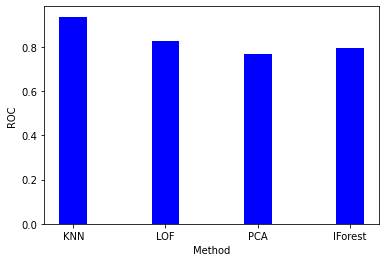

In [50]:
roc_mean=[ np.average(knn_roc), np.average(lof_roc), np.average(pca_roc), np.average(iforest_roc)]
name = ["KNN" , "LOF" , "PCA","IForest"]
plt.bar(name,roc_mean,width=0.3,color='blue')
plt.xlabel("Method")
plt.ylabel("ROC")
plt.show()

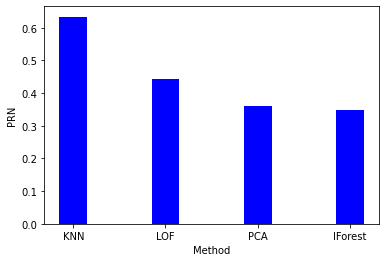

In [53]:
prn_mean=[ np.average(knn_prn), np.average(lof_prn), np.average(pca_prn), np.average(iforest_prn)]
name = ["KNN" , "LOF" , "PCA","IForest"]
plt.bar(name,prn_mean ,width=0.3,color='blue')
plt.xlabel("Method")
plt.ylabel("PRN")
plt.show()

由结果我们可以看出，在数据集abalone上，KNN模型的ROC和PRN效果要比其他三种要好，PCA和IForest效果要差一点